In [5]:
import pandas as pd
import numpy as np

def load_and_clean(path, sheet='BD'):
    """Lit l’Excel, gère les virgules décimales, renvoie un DataFrame indexé par année."""
    df = pd.read_excel(path, sheet_name=sheet)
    df.set_index('Annee', inplace=True)

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = (df[col].astype(str)
                               .str.replace(',', '.')
                               .str.replace(' ', '')
                               .str.replace('−', '-')
                               .str.strip())
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# --- utilisez votre chemin Windows exactement comme ci-dessous ---
file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = load_and_clean(file_path)       # <- df prêt pour les étapes suivantes


In [6]:
def describe_quick(df):
    desc = df.describe().T[['min', 'mean', 'max']]
    print(desc.round(2))

describe_quick(df)



                                    min      mean        max
Auto_Longueur_km                 407.00   1363.28    2511.00
Chambres                       50000.00  85552.64  137886.00
Hopital_Lits_total             23000.00  30952.32   44000.00
Dette_%PIB                        42.00     57.87      72.20
Croissance_PIB_%                  -7.20      3.70       8.20
Deficit_budgétaire_%PIB           -7.15     -3.92       0.63
Chomage                            8.91     10.03      13.58
Nombre de touristes(millions)      2.80      8.57      17.40
Score GPI                          2.01      2.07       2.16


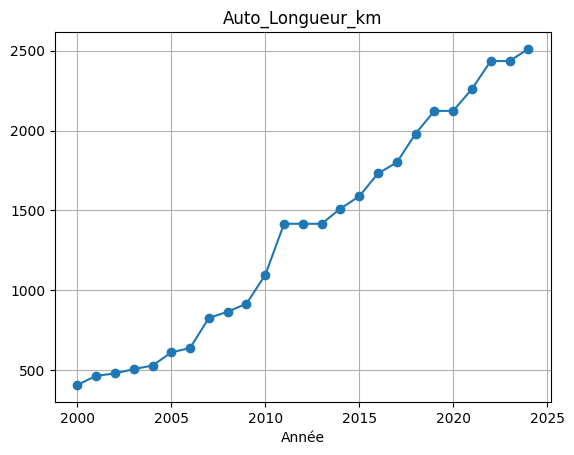

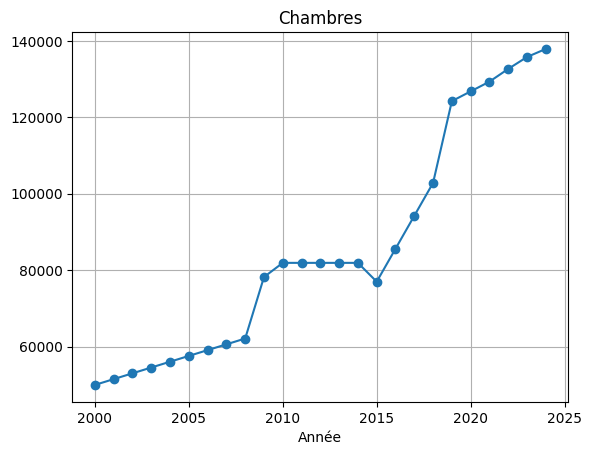

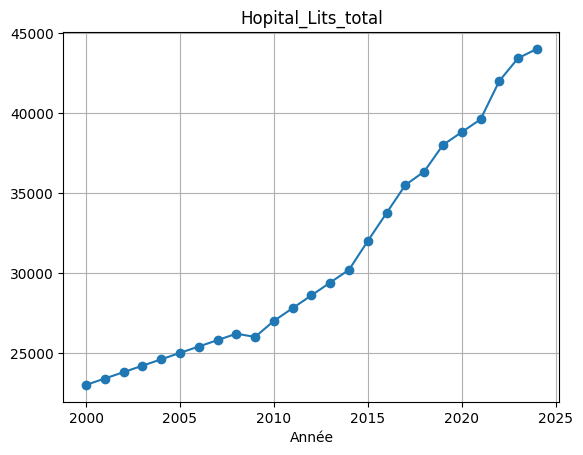

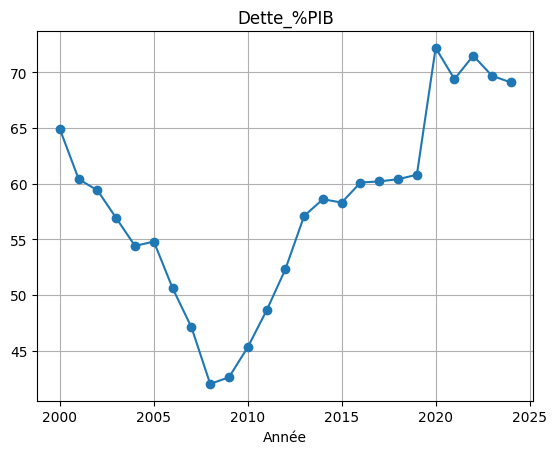

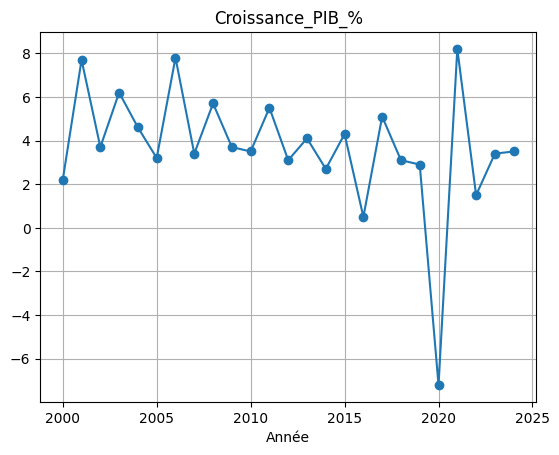

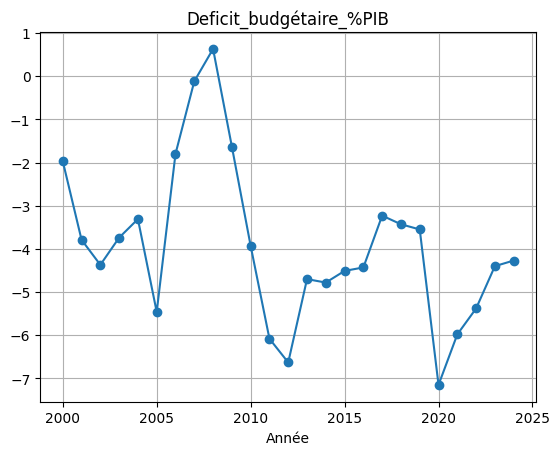

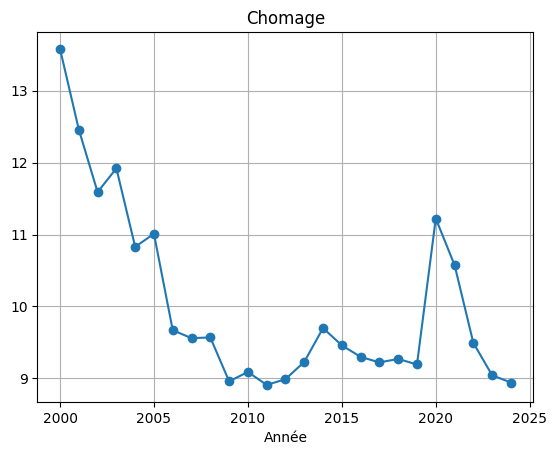

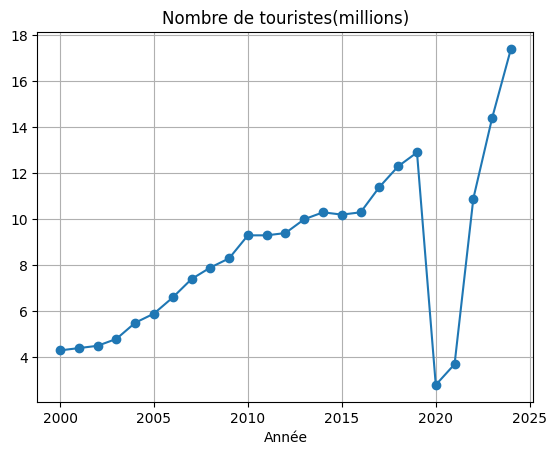

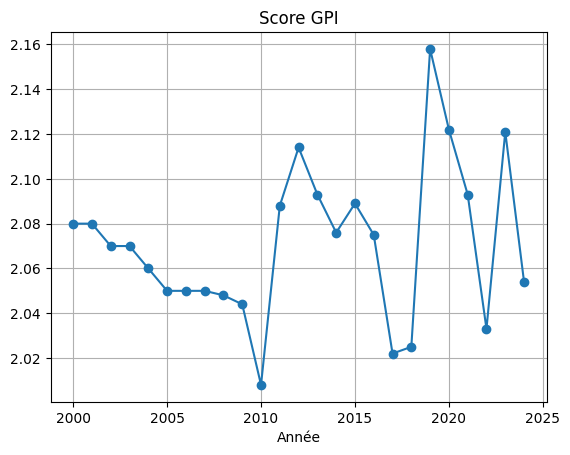

In [7]:
import matplotlib.pyplot as plt

def plot_series(df, save=False):
    for col in df.columns:
        plt.figure()
        plt.plot(df.index, df[col], marker='o')
        plt.title(col)
        plt.xlabel('Année')
        plt.grid(True)
        if save:
            plt.savefig(f'plots/{col}.png', dpi=150, bbox_inches='tight')
        plt.show()

# plot_series(df)  # décommentez pour afficher
plot_series(df)


In [8]:
import pandas as pd
import pmdarima as pm

# 1. Charger et nettoyer les données
def load_and_clean(path, sheet='BD'):
    df = pd.read_excel(path, sheet_name=sheet)
    df.set_index('Annee', inplace=True)
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = (df[col].astype(str)
                                 .str.replace(',', '.')
                                 .str.replace(' ', '')
                                 .str.replace('−', '-')
                                 .str.strip())
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = load_and_clean(file_path)

# 2. Détection SARIMA optimale pour chaque variable
results_list = []

for col in df.columns:
    serie = df[col].dropna()
    try:
        # Ici on suppose données annuelles => s=5 si saisonnalité tous les 5 ans
        model = pm.auto_arima(
            serie,
            seasonal=True,
            m=5,  # à adapter si tes données sont mensuelles ou trimestrielles
            stepwise=True,
            suppress_warnings=True,
            trace=False
        )
        results_list.append({
            "Variable": col,
            "SARIMA": model.order,
            "Saison": model.seasonal_order,
            "AIC": model.aic(),
            "BIC": model.bic()
        })
    except Exception as e:
        results_list.append({
            "Variable": col,
            "SARIMA": None,
            "Saison": None,
            "AIC": None,
            "BIC": None
        })
        print(f"⚠️ Erreur pour {col}: {e}")

# 3. Tableau récapitulatif
results_df = pd.DataFrame(results_list)
print(results_df)

# Enregistrer pour ton rapport
results_df.to_excel("SARIMA_Selection.xlsx", index=False)



                        Variable     SARIMA        Saison         AIC  \
0               Auto_Longueur_km  (0, 1, 0)  (0, 0, 0, 5)  281.924258   
1                       Chambres  (0, 1, 0)  (0, 0, 0, 5)  485.022996   
2             Hopital_Lits_total  (0, 2, 0)  (0, 0, 0, 5)  364.359499   
3                     Dette_%PIB  (2, 0, 2)  (1, 0, 0, 5)  135.318971   
4               Croissance_PIB_%  (1, 0, 1)  (0, 1, 0, 5)  101.810588   
5        Deficit_budgétaire_%PIB  (2, 0, 0)  (0, 0, 0, 5)   94.831881   
6                        Chomage  (0, 1, 0)  (0, 1, 0, 5)   45.017867   
7  Nombre de touristes(millions)  (0, 0, 1)  (0, 1, 0, 5)   96.538911   
8                      Score GPI  (0, 0, 0)  (0, 0, 0, 5)  -93.842520   

          BIC  
0  284.280366  
1  487.379104  
2  365.494993  
3  143.851102  
4  105.793517  
5   99.707384  
6   45.962306  
7   99.526108  
8  -91.404768  


In [9]:
import statsmodels.api as sm
from scipy.stats import f

def chow_test(y, X, break_index):
    """F et p-value du test de Chow avec un point de cassure unique."""
    full = sm.OLS(y, X).fit()
    sse_full = np.square(full.resid).sum()

    y1, X1 = y[:break_index], X[:break_index]
    y2, X2 = y[break_index:], X[break_index:]
    m1, m2 = sm.OLS(y1, X1).fit(), sm.OLS(y2, X2).fit()
    sse1, sse2 = np.square(m1.resid).sum(), np.square(m2.resid).sum()

    k = X.shape[1]
    n = len(y)
    F = ((sse_full - (sse1 + sse2)) / k) / ((sse1 + sse2) / (n - 2*k))
    p = 1 - f.cdf(F, k, n - 2*k)
    return F, p

def chow_pipeline(df, break_year=2025, horizon=10):
    out = []
    for col in df.columns:
        ser = df[col].dropna()
        if len(ser) < 10:
            continue
        fc, order = arima_forecast(ser, horizon)
        ser_ext = pd.concat([ser, fc])
        t = np.arange(len(ser_ext))
        X = sm.add_constant(t)
        idx_break = ser_ext.index.get_loc(break_year)
        F, p = chow_test(ser_ext.values, X, idx_break)
        out.append({'Variable': col, 'ARIMA': order, 'F-stat': round(F, 3), 'p-val': round(p, 4)})
    return pd.DataFrame(out).set_index('Variable').sort_values('p-val')

chow_results = chow_pipeline(df)
print(chow_results)


NameError: name 'arima_forecast' is not defined

In [10]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- Charger et nettoyer les données ---
def load_and_clean(path, sheet='BD'):
    df = pd.read_excel(path, sheet_name=sheet)

    # Nettoyage : remplacer virgules et espaces dans toutes les colonnes sauf Annee
    for col in df.columns:
        if col != 'Annee':
            df[col] = df[col].astype(str).str.replace(',', '.').str.replace(' ', '').str.replace('−', '-').str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.set_index('Annee', inplace=True)
    return df

file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = load_and_clean(file_path)

# --- Fonction test ADF ---
def adf_test(series, signif=0.05, name=''):
    """Applique le test ADF et affiche le résultat."""
    result = adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    print(f"--- Test ADF pour {name} ---")
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {p_value:.4f}")
    if p_value <= signif:
        print("✅ Série stationnaire (rejette H0)")
    else:
        print("⚠️ Série non stationnaire (ne rejette pas H0)")
    print("\n")
    return {
        'Variable': name,
        'ADF Statistic': result[0],
        'p-value': p_value,
        'Lags Used': result[2],
        'Observations': result[3]
    }

# --- Appliquer à toutes les colonnes ---
results = []
for col in df.columns:
    results.append(adf_test(df[col], name=col))

# --- Résumé final en DataFrame ---
results_df = pd.DataFrame(results)
print(results_df)


--- Test ADF pour Auto_Longueur_km ---
ADF Statistic : 0.7790
p-value       : 0.9913
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Chambres ---
ADF Statistic : 1.8649
p-value       : 0.9985
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Hopital_Lits_total ---
ADF Statistic : 3.2081
p-value       : 1.0000
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Dette_%PIB ---
ADF Statistic : -0.7239
p-value       : 0.8405
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Croissance_PIB_% ---
ADF Statistic : -6.5829
p-value       : 0.0000
✅ Série stationnaire (rejette H0)


--- Test ADF pour Deficit_budgétaire_%PIB ---
ADF Statistic : -2.7421
p-value       : 0.0670
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Chomage ---
ADF Statistic : -2.1082
p-value       : 0.2412
⚠️ Série non stationnaire (ne rejette pas H0)


--- Test ADF pour Nombre de touristes(millions) ---
ADF Statistic : -7.0728
p-value       :

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

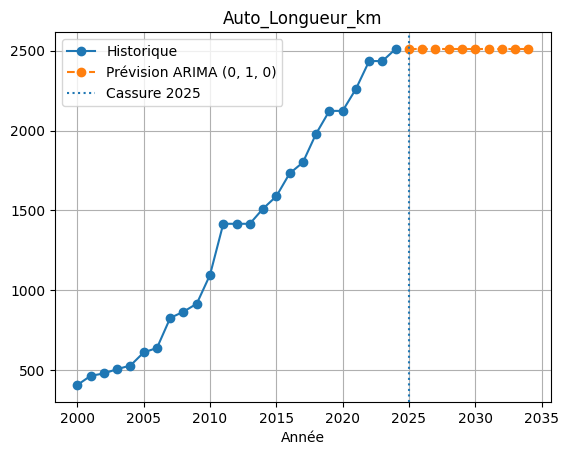

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

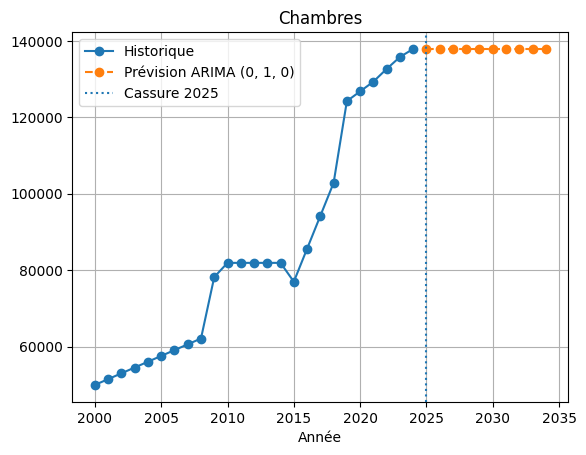

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

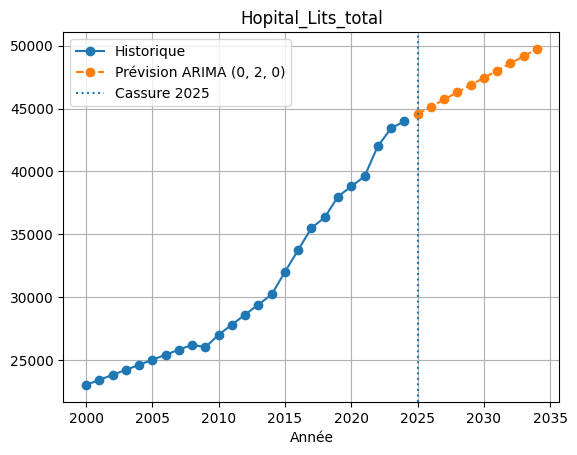

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

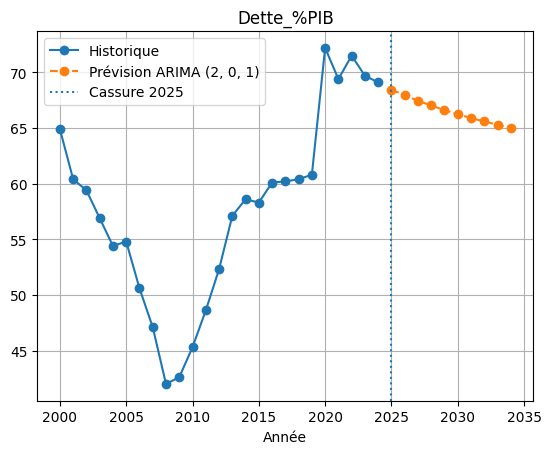

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

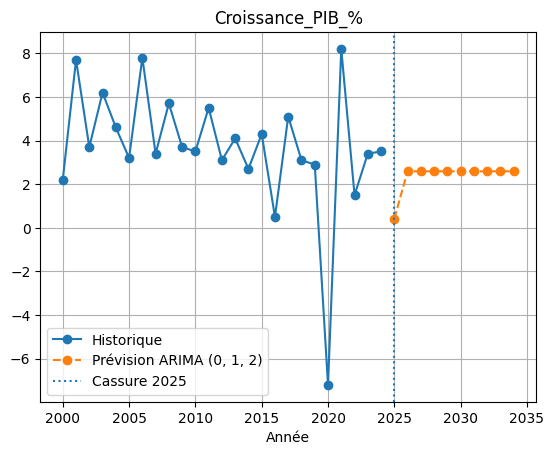

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

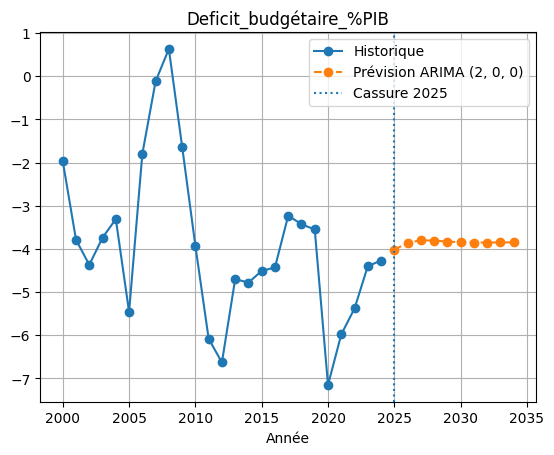

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

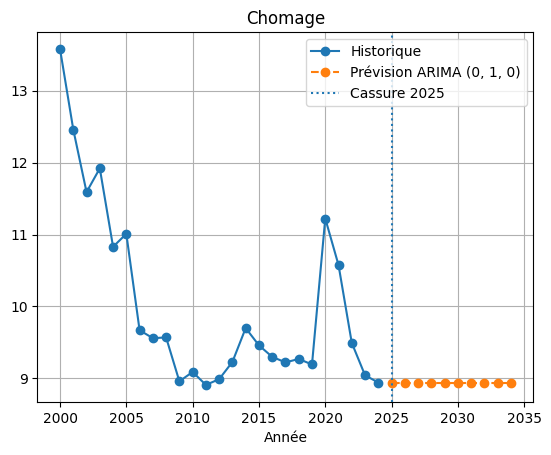

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

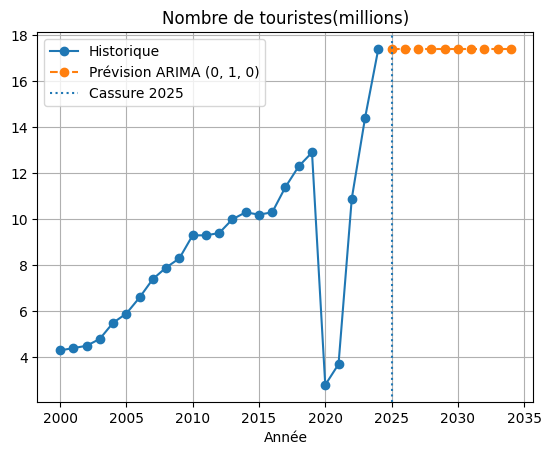

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results 

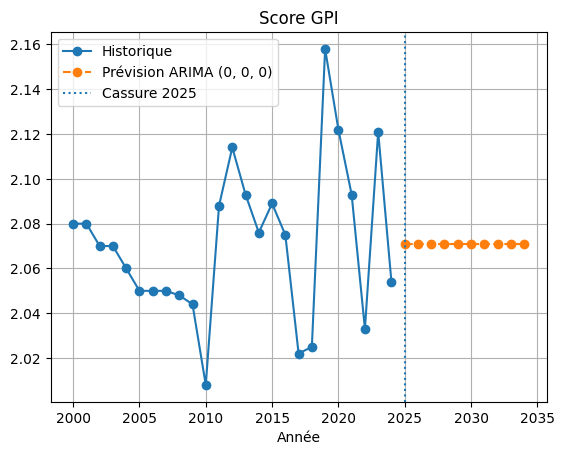

In [11]:
# ==============================
# 1. Imports et paramètres
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
try:
    from pmdarima import auto_arima          # sélection automatique (si dispo)
    AUTO = True
except ModuleNotFoundError:
    AUTO = False

# --- chemin vers votre fichier Excel ---
file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"   # <-- modifiez si besoin
sheet_name = "BD"                                            # nom de la feuille
forecast_horizon = 10                                        # 2025-2034
break_year = 2025

# ==============================
# 2. Charger & nettoyer
# ==============================
df = pd.read_excel(file_path, sheet_name=sheet_name)
df.set_index('Annee', inplace=True)

for col in df.columns:
    if df[col].dtype == object:                       # «3,14» → «3.14»
        df[col] = (df[col].astype(str)
                             .str.replace(',', '.')
                             .str.replace('−', '-')
                             .str.strip())
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ==============================
# 3. Fonction de prévision ARIMA
# ==============================
def arima_predict(series, horizon):
    if AUTO:
        try:
            sel = auto_arima(series, seasonal=False, stepwise=True,
                             suppress_warnings=True, max_p=3, max_q=3)
            order = sel.order
        except Exception:
            order = (1, 1, 1)
    else:
        order = (1, 1, 1)

    model = ARIMA(series, order=order).fit()
    fc = model.get_forecast(steps=horizon).predicted_mean
    # ré-indexer (ex : 2025-2034)
    fc.index = range(series.index[-1] + 1, series.index[-1] + horizon + 1)
    return fc, order

# ==============================
# 4. Boucle de tracé
# ==============================
for col in df.columns:
    serie_hist = df[col].dropna()
    if len(serie_hist) < 10:                    # trop courte → on saute
        continue

    forecast, ordre = arima_predict(serie_hist, forecast_horizon)

    # ---------- Figure ----------
    plt.figure()
    plt.plot(serie_hist.index, serie_hist, marker='o', label='Historique')
    plt.plot(forecast.index, forecast, marker='o', linestyle='--',
             label=f'Prévision ARIMA {ordre}')
    plt.axvline(break_year, linestyle=':', label=f'Cassure {break_year}')
    plt.title(col)
    plt.xlabel('Année')
    plt.grid(True)
    plt.legend()
    plt.show()


In [12]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Chargement des données
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')

# Nettoyage des données
df['Deficit_budgétaire_%PIB'] = df['Deficit_budgétaire_%PIB'].str.replace(',', '.').astype(float)
df['Nombre de touristes(millions)'] = df['Nombre de touristes(millions)'].str.replace(',', '.').astype(float)
df['Score GPI'] = df['Score GPI'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(str)

# Initialisation de l'application Dash
app = dash.Dash(__name__)
server = app.server

# Layout du dashboard
app.layout = html.Div([
    html.H1("Dashboard d'Analyse Économique et Sociale", style={'textAlign': 'center'}),
    
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='indicator-dropdown',
                options=[
                    {'label': 'Longueur Autoroutes (km)', 'value': 'Auto_Longueur_km'},
                    {'label': 'Nombre de Chambres', 'value': 'Chambres'},
                    {'label': 'Lits Hospitaliers', 'value': 'Hopital_Lits_total'},
                    {'label': 'Dette (% PIB)', 'value': 'Dette_%PIB'},
                    {'label': 'Croissance PIB (%)', 'value': 'Croissance_PIB_%'},
                    {'label': 'Déficit Budgétaire (% PIB)', 'value': 'Deficit_budgétaire_%PIB'},
                    {'label': 'Taux de Chômage (%)', 'value': 'Chomage'},
                    {'label': 'Nombre de Touristes (millions)', 'value': 'Nombre de touristes(millions)'},
                    {'label': 'Score GPI', 'value': 'Score GPI'}
                ],
                value='Auto_Longueur_km',
                style={'width': '100%'}
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        html.Div([
            dcc.RadioItems(
                id='chart-type',
                options=[
                    {'label': 'Ligne', 'value': 'line'},
                    {'label': 'Barre', 'value': 'bar'}
                ],
                value='line',
                labelStyle={'display': 'inline-block', 'margin-right': '10px'}
            )
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),
    
    dcc.Graph(id='indicator-graph'),
    
    html.Div([
        html.Div([
            dcc.Graph(id='debt-deficit-graph')
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        html.Div([
            dcc.Graph(id='gdp-unemployment-graph')
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),
    
    html.Div([
        dcc.Graph(id='infrastructure-graph')
    ]),
    
    html.Div([
        dcc.RangeSlider(
            id='year-slider',
            min=2000,
            max=2024,
            step=1,
            marks={year: str(year) for year in range(2000, 2025, 5)},
            value=[2000, 2024]
        )
    ], style={'margin': '20px 0'})
])

# Callback pour le graphique principal
@app.callback(
    Output('indicator-graph', 'figure'),
    [Input('indicator-dropdown', 'value'),
     Input('chart-type', 'value'),
     Input('year-slider', 'value')]
)
def update_indicator_graph(selected_indicator, chart_type, year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) & 
                     (df['Annee'].astype(int) <= year_range[1])]
    
    if chart_type == 'line':
        fig = px.line(filtered_df, x='Annee', y=selected_indicator, 
                      title=f'Évolution de {selected_indicator}',
                      markers=True)
    else:
        fig = px.bar(filtered_df, x='Annee', y=selected_indicator, 
                     title=f'Évolution de {selected_indicator}')
    
    fig.update_layout(
        xaxis_title='Année',
        yaxis_title=selected_indicator,
        hovermode='x unified'
    )
    
    return fig

# Callback pour le graphique dette/déficit
@app.callback(
    Output('debt-deficit-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_debt_deficit_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) & 
                     (df['Annee'].astype(int) <= year_range[1])]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Dette_%PIB'], 
                   name="Dette (% PIB)", mode='lines+markers'),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Deficit_budgétaire_%PIB'], 
                   name="Déficit (% PIB)", mode='lines+markers'),
        secondary_y=True,
    )
    
    fig.update_layout(
        title_text="Dette et Déficit Budgétaire (% PIB)",
        hovermode='x unified'
    )
    
    fig.update_yaxes(title_text="Dette (% PIB)", secondary_y=False)
    fig.update_yaxes(title_text="Déficit (% PIB)", secondary_y=True)
    
    return fig

# Callback pour le graphique PIB/chômage
@app.callback(
    Output('gdp-unemployment-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_gdp_unemployment_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) & 
                     (df['Annee'].astype(int) <= year_range[1])]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Croissance_PIB_%'], 
                   name="Croissance PIB (%)", mode='lines+markers'),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Chomage'], 
                   name="Chômage (%)", mode='lines+markers'),
        secondary_y=True,
    )
    
    fig.update_layout(
        title_text="Croissance du PIB et Taux de Chômage", 
        hovermode='x unified'
    )
    
    fig.update_yaxes(title_text="Croissance PIB (%)", secondary_y=False)
    fig.update_yaxes(title_text="Chômage (%)", secondary_y=True)
    
    return fig

# Callback pour le graphique des infrastructures
@app.callback(
    Output('infrastructure-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_infrastructure_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) & 
                     (df['Annee'].astype(int) <= year_range[1])]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Auto_Longueur_km'], 
                   name="Autoroutes (km)", mode='lines+markers'),
        secondary_y=False,
    )
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Chambres'], 
                   name="Chambres", mode='lines+markers'),
        secondary_y=True,
    )
    
    fig.add_trace(
        go.Scatter(x=filtered_df['Annee'], y=filtered_df['Hopital_Lits_total'], 
                   name="Lits Hospitaliers", mode='lines+markers'),
        secondary_y=True,
    )
    
    fig.update_layout(
        title_text="Évolution des Infrastructures",
        hovermode='x unified'
    )
    
    fig.update_yaxes(title_text="Autoroutes (km)", secondary_y=False)
    fig.update_yaxes(title_text="Chambres / Lits Hospitaliers", secondary_y=True)
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

AttributeError: Can only use .str accessor with string values!

In [13]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --------- Chargement des données ----------
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')

# --------- Nettoyage ----------
df['Deficit_budgétaire_%PIB'] = df['Deficit_budgétaire_%PIB'].astype(str).str.replace(',', '.').astype(float)
df['Nombre de touristes(millions)'] = df['Nombre de touristes(millions)'].astype(str).str.replace(',', '.').astype(float)
df['Score GPI'] = df['Score GPI'].astype(str).str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(str)  # on garde string pour l’axe X

# --------- App Dash ----------
app = dash.Dash(__name__)
server = app.server

# --------- Layout ----------
app.layout = html.Div([
    html.H1("Dashboard d'Analyse Économique et Sociale", style={'textAlign': 'center'}),

    # Ligne de contrôles
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='indicator-dropdown',
                options=[
                    {'label': 'Longueur Autoroutes (km)', 'value': 'Auto_Longueur_km'},
                    {'label': 'Nombre de Chambres', 'value': 'Chambres'},
                    {'label': 'Lits Hospitaliers', 'value': 'Hopital_Lits_total'},
                    {'label': 'Dette (% PIB)', 'value': 'Dette_%PIB'},
                    {'label': 'Croissance PIB (%)', 'value': 'Croissance_PIB_%'},
                    {'label': 'Déficit Budgétaire (% PIB)', 'value': 'Deficit_budgétaire_%PIB'},
                    {'label': 'Taux de Chômage (%)', 'value': 'Chomage'},
                    {'label': 'Nombre de Touristes (millions)', 'value': 'Nombre de touristes(millions)'},
                    {'label': 'Score GPI', 'value': 'Score GPI'}
                ],
                value='Auto_Longueur_km',
                style={'width': '100%'}
            )
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            dcc.RadioItems(
                id='chart-type',
                options=[
                    {'label': 'Ligne', 'value': 'line'},
                    {'label': 'Barre', 'value': 'bar'}
                ],
                value='line',
                labelStyle={'display': 'inline-block', 'margin-right': '10px'}
            )
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='indicator-graph'),

    # Deux graphiques côte à côte (Dette/Déficit & PIB/Chômage)
    html.Div([
        html.Div([dcc.Graph(id='debt-deficit-graph')], style={'width': '48%', 'display': 'inline-block'}),
        html.Div([dcc.Graph(id='gdp-unemployment-graph')], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    # Nouveau : Tourisme & GPI (double axe)
    html.Div([dcc.Graph(id='tourism-gpi-graph')]),

    # Infrastructures
    html.Div([dcc.Graph(id='infrastructure-graph')]),

    # Slider années
    html.Div([
        dcc.RangeSlider(
            id='year-slider',
            min=2000,
            max=2024,
            step=1,
            marks={year: str(year) for year in range(2000, 2025, 5)},
            value=[2000, 2024]
        )
    ], style={'margin': '20px 0'})
])

# --------- Callbacks ----------

# Graphique principal (dropdown + type)
@app.callback(
    Output('indicator-graph', 'figure'),
    [Input('indicator-dropdown', 'value'),
     Input('chart-type', 'value'),
     Input('year-slider', 'value')]
)
def update_indicator_graph(selected_indicator, chart_type, year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) &
                     (df['Annee'].astype(int) <= year_range[1])]

    if chart_type == 'line':
        fig = px.line(filtered_df, x='Annee', y=selected_indicator,
                      title=f'Évolution de {selected_indicator}', markers=True)
    else:
        fig = px.bar(filtered_df, x='Annee', y=selected_indicator,
                     title=f'Évolution de {selected_indicator}')

    fig.update_layout(xaxis_title='Année', yaxis_title=selected_indicator, hovermode='x unified')
    return fig

# Dette vs Déficit (double axe)
@app.callback(
    Output('debt-deficit-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_debt_deficit_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) &
                     (df['Annee'].astype(int) <= year_range[1])]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Dette_%PIB'],
                             name="Dette (% PIB)", mode='lines+markers'), secondary_y=False)
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Deficit_budgétaire_%PIB'],
                             name="Déficit (% PIB)", mode='lines+markers'), secondary_y=True)
    fig.update_layout(title_text="Dette et Déficit Budgétaire (% PIB)", hovermode='x unified')
    fig.update_yaxes(title_text="Dette (% PIB)", secondary_y=False)
    fig.update_yaxes(title_text="Déficit (% PIB)", secondary_y=True)
    return fig

# PIB vs Chômage (double axe)
@app.callback(
    Output('gdp-unemployment-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_gdp_unemployment_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) &
                     (df['Annee'].astype(int) <= year_range[1])]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Croissance_PIB_%'],
                             name="Croissance PIB (%)", mode='lines+markers'), secondary_y=False)
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Chomage'],
                             name="Chômage (%)", mode='lines+markers'), secondary_y=True)
    fig.update_layout(title_text="Croissance du PIB et Taux de Chômage", hovermode='x unified')
    fig.update_yaxes(title_text="Croissance PIB (%)", secondary_y=False)
    fig.update_yaxes(title_text="Chômage (%)", secondary_y=True)
    return fig

# *** Nouveau : Tourisme & GPI (double axe) ***
@app.callback(
    Output('tourism-gpi-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_tourism_gpi_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) &
                     (df['Annee'].astype(int) <= year_range[1])]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=filtered_df['Annee'],
                             y=filtered_df['Nombre de touristes(millions)'],
                             name="Touristes (millions)", mode='lines+markers'),
                  secondary_y=False)
    fig.add_trace(go.Scatter(x=filtered_df['Annee'],
                             y=filtered_df['Score GPI'],
                             name="Score GPI", mode='lines+markers'),
                  secondary_y=True)

    fig.update_layout(title_text="Tourisme et Indice de Paix (GPI)", hovermode='x unified')
    fig.update_yaxes(title_text="Touristes (millions)", secondary_y=False)
    fig.update_yaxes(title_text="Score GPI (plus bas = plus pacifique)", secondary_y=True)
    return fig

# Infrastructures
@app.callback(
    Output('infrastructure-graph', 'figure'),
    [Input('year-slider', 'value')]
)
def update_infrastructure_graph(year_range):
    filtered_df = df[(df['Annee'].astype(int) >= year_range[0]) &
                     (df['Annee'].astype(int) <= year_range[1])]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Auto_Longueur_km'],
                             name="Autoroutes (km)", mode='lines+markers'),
                  secondary_y=False)
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Chambres'],
                             name="Chambres (hôtelières)", mode='lines+markers'),
                  secondary_y=True)
    fig.add_trace(go.Scatter(x=filtered_df['Annee'], y=filtered_df['Hopital_Lits_total'],
                             name="Lits Hospitaliers", mode='lines+markers'),
                  secondary_y=True)

    fig.update_layout(title_text="Évolution des Infrastructures", hovermode='x unified')
    fig.update_yaxes(title_text="Autoroutes (km)", secondary_y=False)
    fig.update_yaxes(title_text="Chambres / Lits", secondary_y=True)
    return fig

# --------- Run ----------
if __name__ == '__main__':
    app.run_server(debug=True)


In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Chargement des données
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')

# Nettoyage des données (ex: conversion des virgules en points pour les décimaux)
df['Deficit_budgétaire_%PIB'] = df['Deficit_budgétaire_%PIB'].str.replace(',', '.').astype(float)
df['Nombre de touristes(millions)'] = df['Nombre de touristes(millions)'].str.replace(',', '.').astype(float)
df['Score GPI'] = df['Score GPI'].str.replace(',', '.').astype(float)

# Sélection des variables à tester
variables = ['Auto_Longueur_km', 'Chambres', 'Hopital_Lits_total', 
             'Dette_%PIB', 'Croissance_PIB_%', 'Deficit_budgétaire_%PIB', 'Chomage','Nombre de touristes(millions)','Score GPI']

# Fonction pour effectuer le test ADF et interpréter les résultats
def test_adf(serie, nom):
    result = adfuller(serie.dropna(), autolag='AIC')  # Critère AIC pour le lag
    p_value = result[1]
    conclusion = "Stationnaire" if p_value < 0.05 else "Non-Stationnaire"
    return {
        'Variable': nom,
        'Statistique ADF': round(result[0], 3),
        'p-value': round(p_value, 4),
        'Lag utilisé': result[2],
        'Conclusion': conclusion
    }

# Application à toutes les variables
resultats = [test_adf(df[var], var) for var in variables]
df_resultats = pd.DataFrame(resultats)
print(df_resultats.to_markdown(index=False))

AttributeError: Can only use .str accessor with string values!


🔎 Analyzing: Annee


c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning:

invalid value encountered in divide

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning:

Matrix is singular. Using pinv.



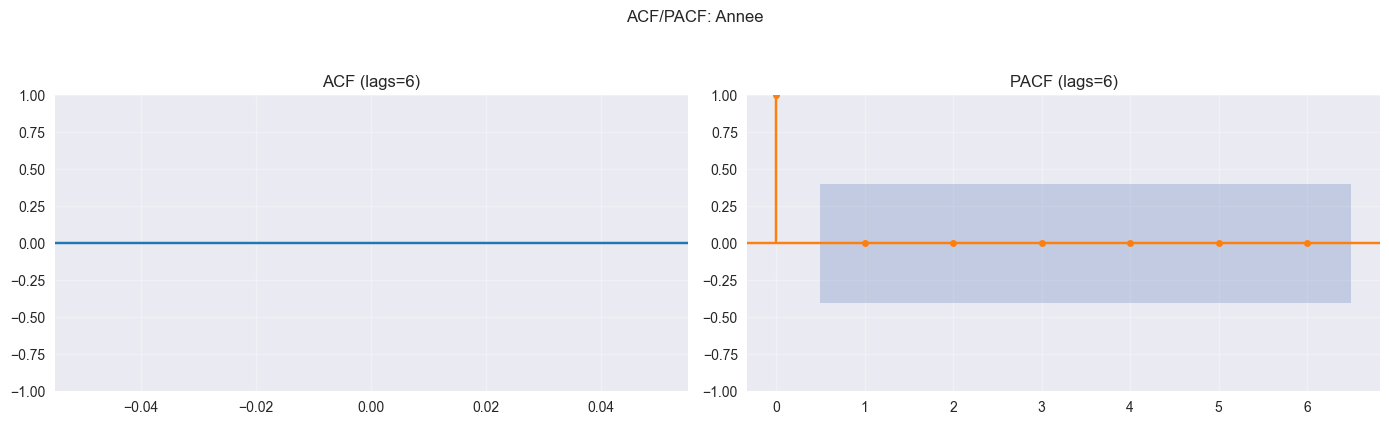


🔎 Analyzing: Auto_Longueur_km


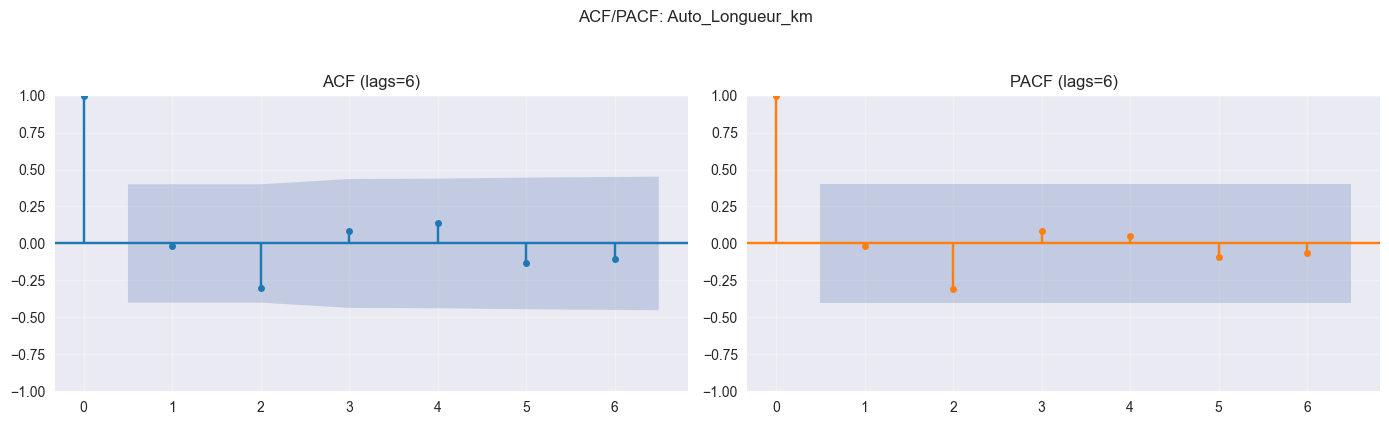


🔎 Analyzing: Chambres


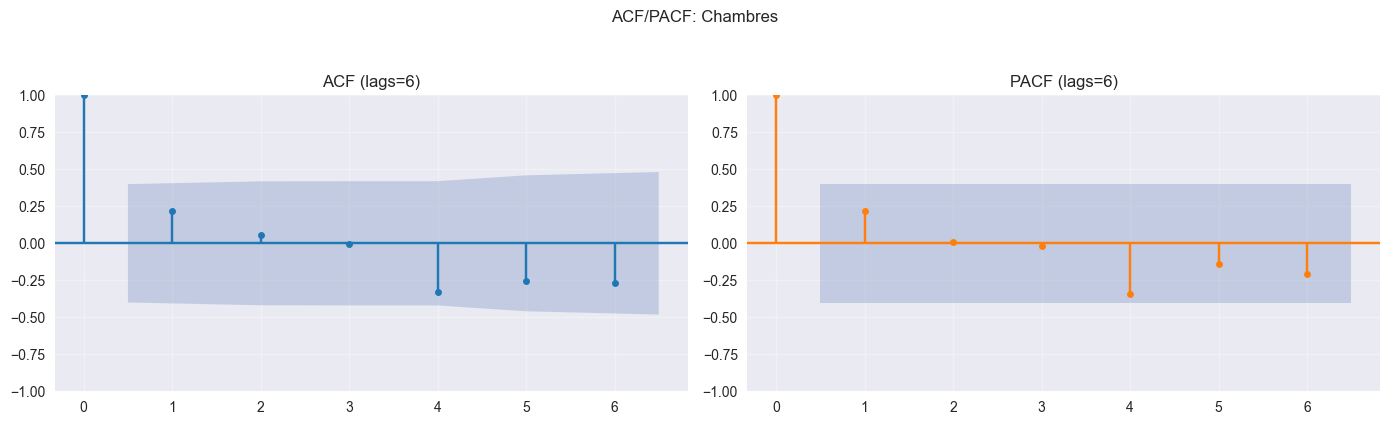


🔎 Analyzing: Hopital_Lits_total


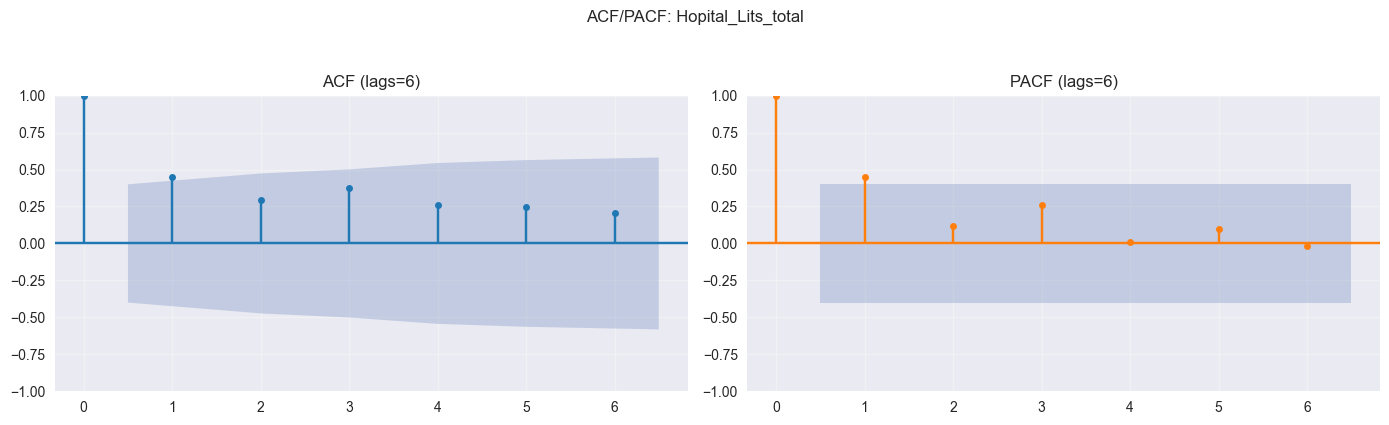


🔎 Analyzing: Dette_%PIB


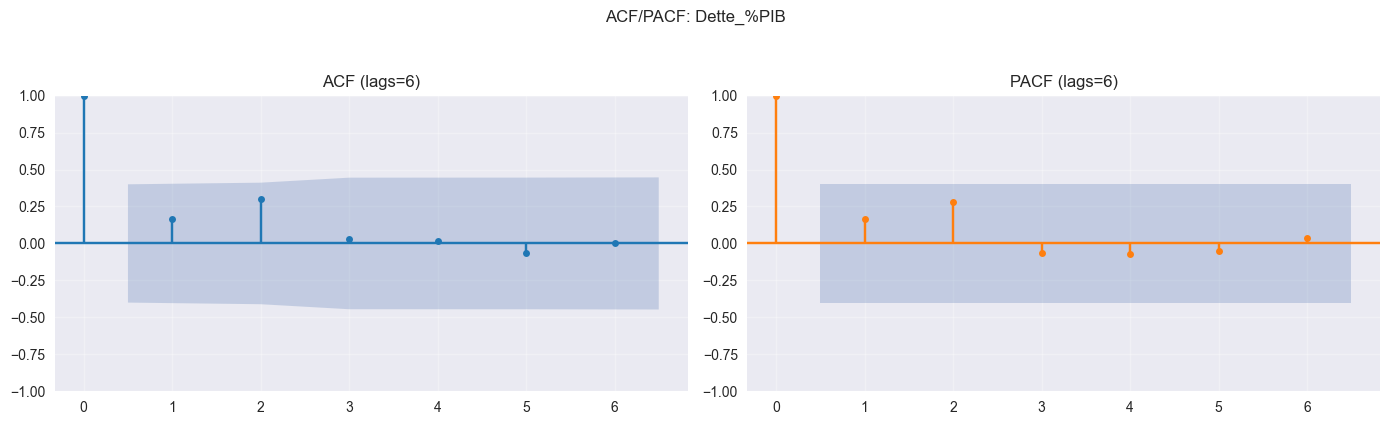


🔎 Analyzing: Croissance_PIB_%


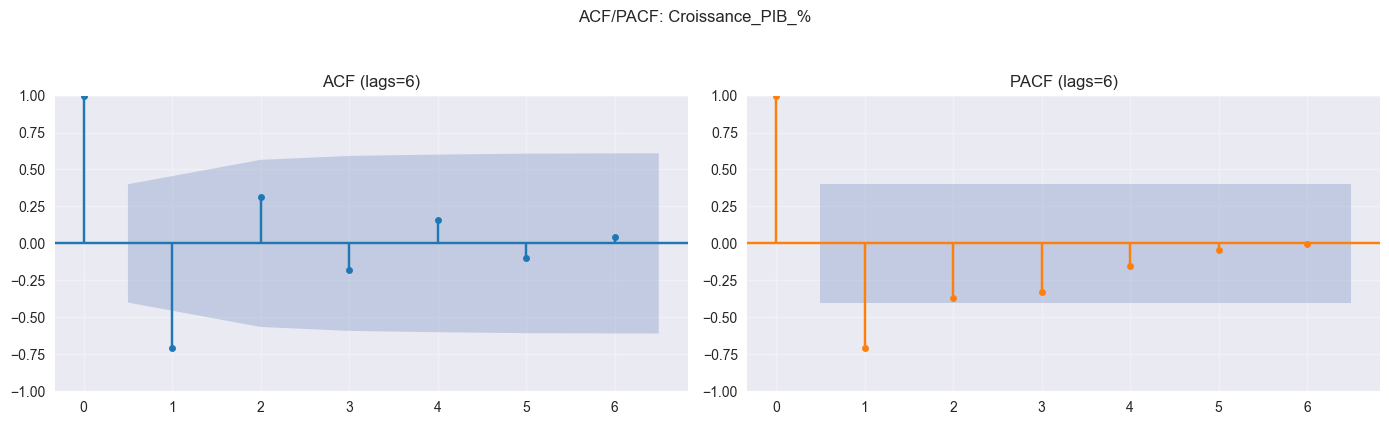


🔎 Analyzing: Deficit_budgétaire_%PIB


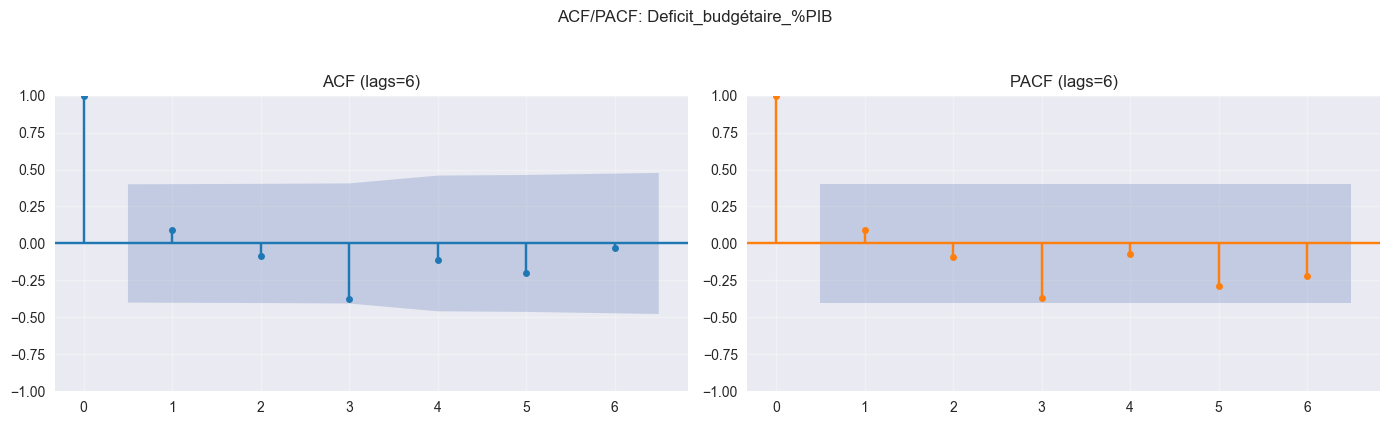


🔎 Analyzing: Chomage


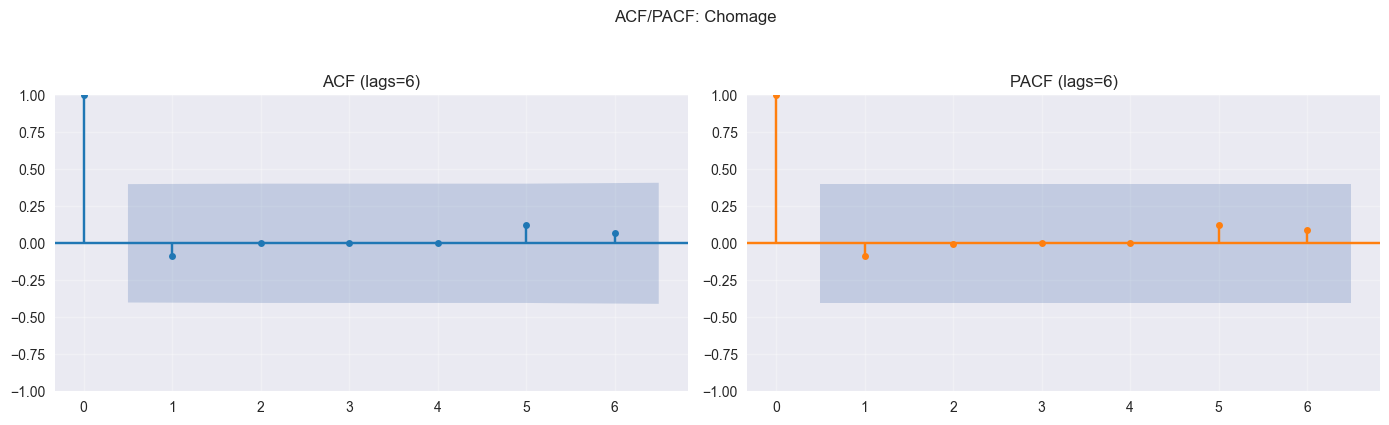


🔎 Analyzing: Nombre de touristes(millions)


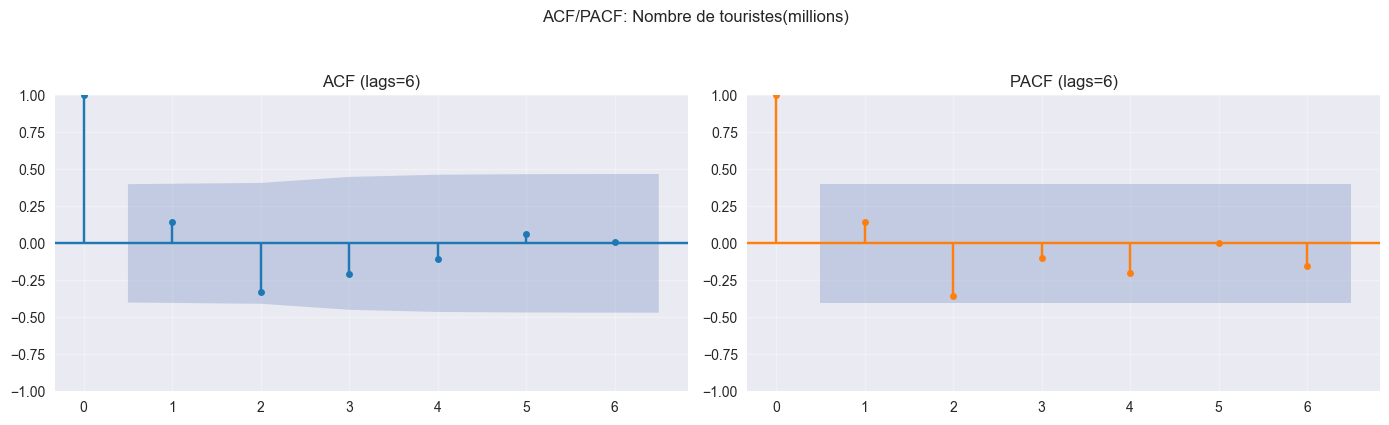


🔎 Analyzing: Score GPI


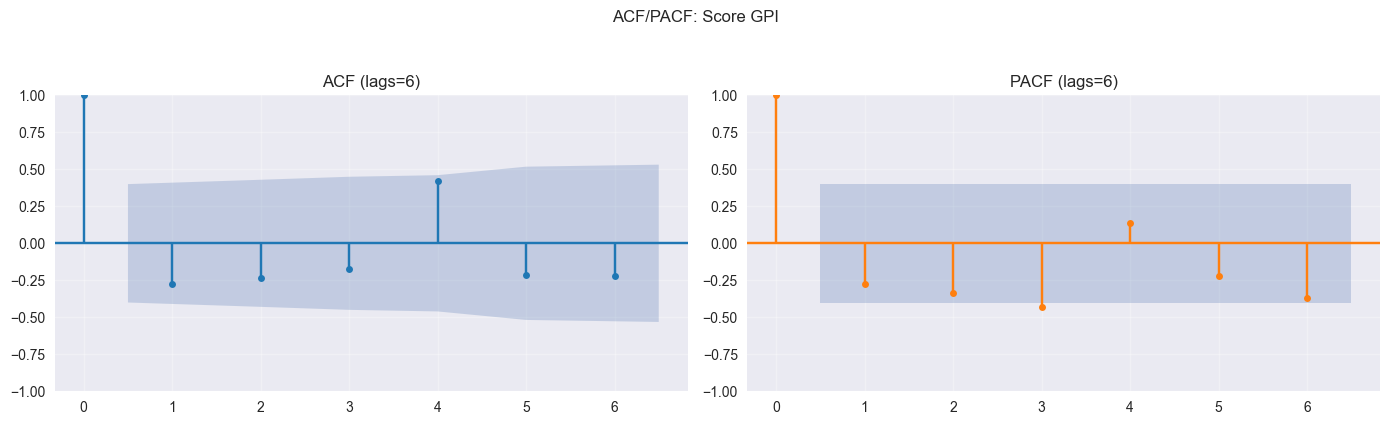

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Safe matplotlib configuration
try:
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
except:
    plt.style.use('ggplot')  # Fallback style
finally:
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['figure.max_open_warning'] = 30

def safe_plot_acf_pacf(series, title="", max_lags=None):
    """
    Robust ACF/PACF plotting with automatic lag adjustment
    and proper resource management
    """
    # Calculate safe number of lags
    n = len(series)
    safe_lags = min(10, max(n//4, 1)) if max_lags is None else min(max_lags, max(n//2 - 1, 1))
    
    if safe_lags < 1 or n < 4:
        print(f"⚠️ Insufficient data ({n} points) for {title}")
        return
    
    # Create figure with context manager
    with plt.rc_context():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'ACF/PACF: {title}', y=1.05)
        
        try:
            # Plot ACF
            plot_acf(series, lags=safe_lags, ax=ax1, 
                    title=f'ACF (lags={safe_lags})', 
                    color='#1f77b4', vlines_kwargs={'colors': '#1f77b4'})
            ax1.grid(alpha=0.3)
            
            # Plot PACF
            plot_pacf(series, lags=safe_lags, ax=ax2, method='ywm',
                     title=f'PACF (lags={safe_lags})',
                     color='#ff7f0e', vlines_kwargs={'colors': '#ff7f0e'})
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ Error in {title}: {str(e)}")
        finally:
            plt.close(fig)

def analyze_time_series(df):
    """Complete time series analysis with robust error handling"""
    for col in df.select_dtypes(include=np.number).columns:
        print(f"\n🔎 Analyzing: {col}")
        clean_series = df[col].dropna()
        
        if len(clean_series) < 4:
            print(f"⚠️ Skipped - only {len(clean_series)} valid points")
            continue
            
        stationary_series = clean_series.diff().dropna()
        safe_plot_acf_pacf(stationary_series, col)

# Execute analysis
analyze_time_series(df)

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chargement des données
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')
df['Deficit_budgétaire_%PIB'] = df['Deficit_budgétaire_%PIB'].str.replace(',', '.').astype(float)
df.set_index('Annee', inplace=True)

# Sélection de la variable cible (à adapter selon votre besoin)
target_var = 'Auto_Longueur_km'
target = df[target_var].values.reshape(-1, 1)

# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target)

# Création des séquences temporelles
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

AttributeError: Can only use .str accessor with string values!

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction
rf_pred = rf_model.predict(X_test)

# Évaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"RMSE Random Forest: {rf_rmse:.4f}")

NameError: name 'X_train' is not defined

In [18]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"RMSE XGBoost: {xgb_rmse:.4f}")

NameError: name 'X_train' is not defined

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Redimensionnement pour LSTM [échantillons, pas de temps, caractéristiques]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construction du modèle
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Entraînement
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, verbose=0)

# Prédiction et évaluation
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
print(f"RMSE LSTM: {lstm_rmse:.4f}")

NameError: name 'X_train' is not defined

In [20]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train, epochs=50, verbose=0)
hybrid_pred = model.predict(X_test_lstm)
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_pred))
print(f"RMSE CNN-LSTM: {hybrid_rmse:.4f}")

NameError: name 'SEQ_LENGTH' is not defined

In [21]:
results = pd.DataFrame({
    'Modèle': ['Random Forest', 'XGBoost', 'LSTM', 'CNN-LSTM'],
    'RMSE': [rf_rmse, xgb_rmse, lstm_rmse, hybrid_rmse]
})

print(results.sort_values('RMSE'))

NameError: name 'rf_rmse' is not defined

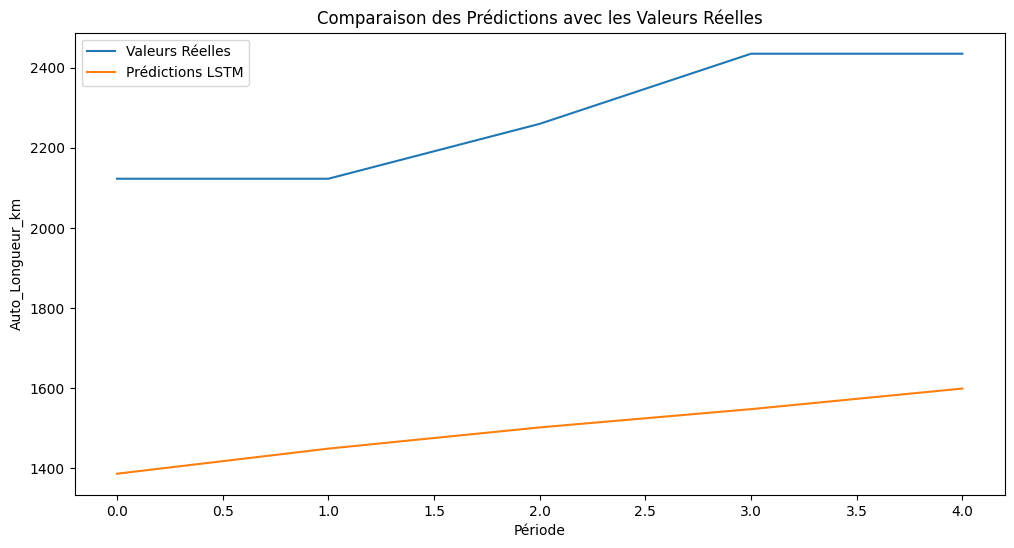

In [11]:
import matplotlib.pyplot as plt

# Inversion de la normalisation pour les vraies valeurs
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_pred_inv = scaler.inverse_transform(lstm_pred.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valeurs Réelles')
plt.plot(lstm_pred_inv, label='Prédictions LSTM')
plt.title('Comparaison des Prédictions avec les Valeurs Réelles')
plt.xlabel('Période')
plt.ylabel(target_var)
plt.legend()
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_pred = best_xgb.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
print(f"RMSE XGBoost optimisé: {best_rmse:.4f}")


NameError: name 'X_train' is not defined

In [23]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Préparation des données corrigée
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
scaled_data = df['Auto_Longueur_km'].values.reshape(-1, 1)
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 2. Construction du modèle avec vérification de shape
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 3. Fonction de prévision corrigée
def forecast_future(model, last_sequence, steps, scaler):
    predictions = []
    current_seq = last_sequence.reshape(1, SEQ_LENGTH, 1)  # Shape correcte [1, timesteps, features]
    
    for _ in range(steps):
        pred = model.predict(current_seq)
        predictions.append(pred[0][0])
        
        # Mise à jour de la séquence
        current_seq = np.roll(current_seq, -1, axis=1)
        current_seq[0, -1, 0] = pred[0][0]
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 4. Entraînement
model.fit(X, y, epochs=100, verbose=0)

# 5. Prévision avec la bonne shape
last_sequence = scaled_data[-SEQ_LENGTH:]  # Garde la shape [3,1]
future_predictions = forecast_future(model, last_sequence, 5, scaler)

print("Prévisions futures:", future_predictions.flatten())

c:\Users\adame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



NameError: name 'scaler' is not defined

In [24]:
# Version avec vérifications de shape
def forecast_future(model, last_sequence, steps, scaler):
    assert last_sequence.shape == (SEQ_LENGTH, 1), f"Mauvaise shape: {last_sequence.shape}"
    
    predictions = []
    current_seq = last_sequence.T.reshape(1, SEQ_LENGTH, 1)
    
    for _ in range(steps):
        pred = model.predict(current_seq, verbose=0)
        predictions.append(pred[0,0])
        
        current_seq = np.append(current_seq[:,1:,:], pred.reshape(1,1,1), axis=1)
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print(f"Shape de last_sequence: {last_sequence.shape}")
print(f"Shape après reshape: {last_sequence.reshape(1, SEQ_LENGTH, 1).shape}")

Shape de last_sequence: (3, 1)
Shape après reshape: (1, 3, 1)


In [25]:
#test de saisonnalite
from scipy.stats import kruskal

# Créer des groupes saisonniers (ex: mois)
groups = [df[df.index.month == month]['Auto_Longueur_km'] for month in range(1, 13)]

stat, p_value = kruskal(*groups)
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ Saisonnalité détectée (p < 0.05)")
else:
    print("→ Aucune saisonnalité significative")

AttributeError: 'RangeIndex' object has no attribute 'month'


=== Analyse de saisonnalité pour Auto_Longueur_km ===


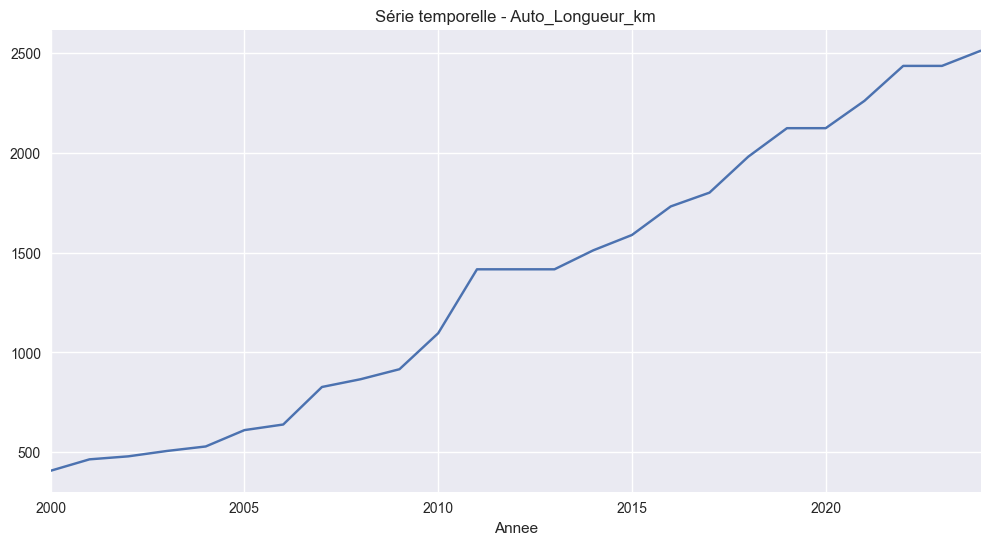

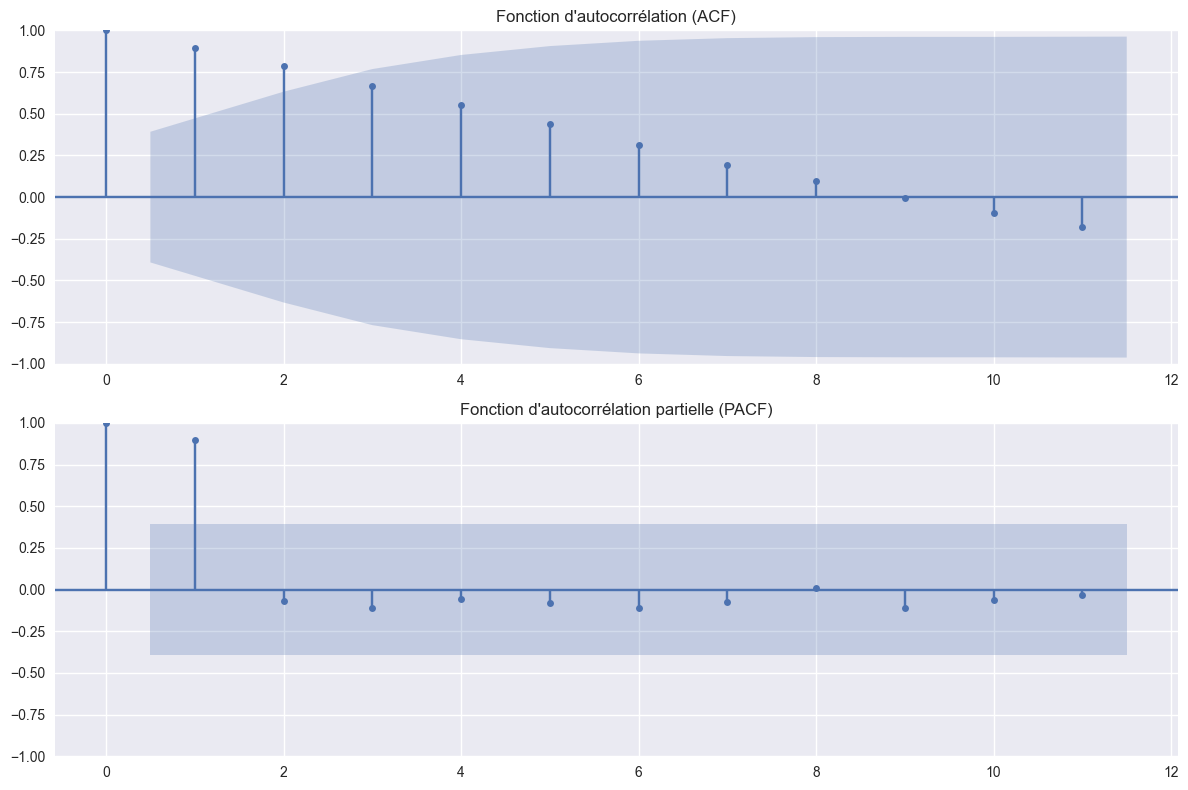

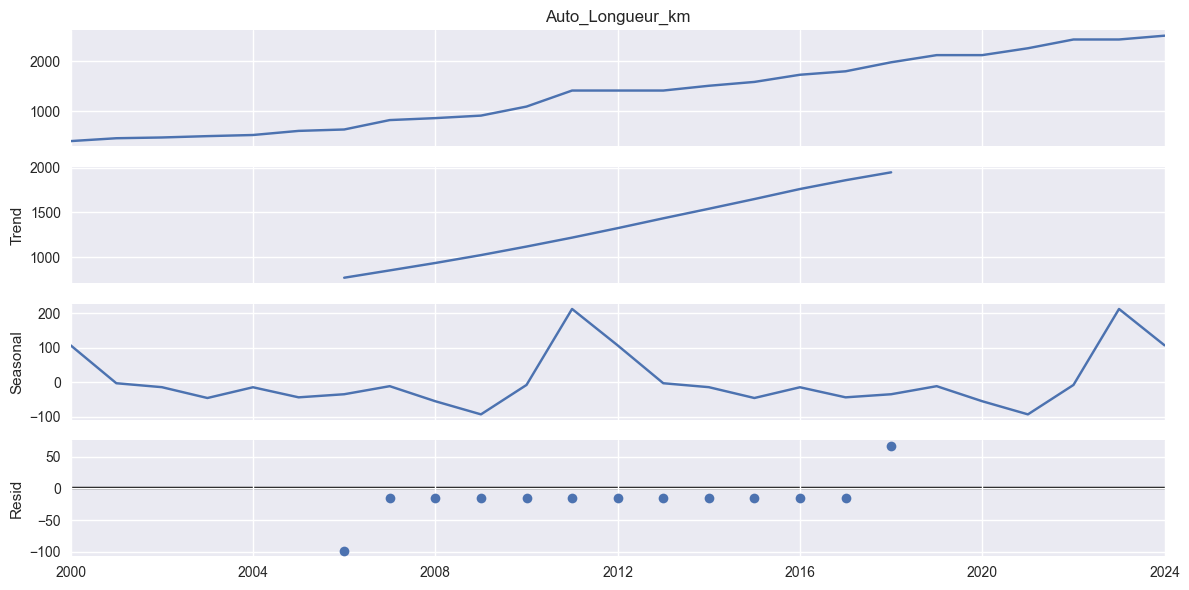

Données insuffisantes pour le test Kruskal-Wallis

=== Analyse de saisonnalité pour Chambres ===


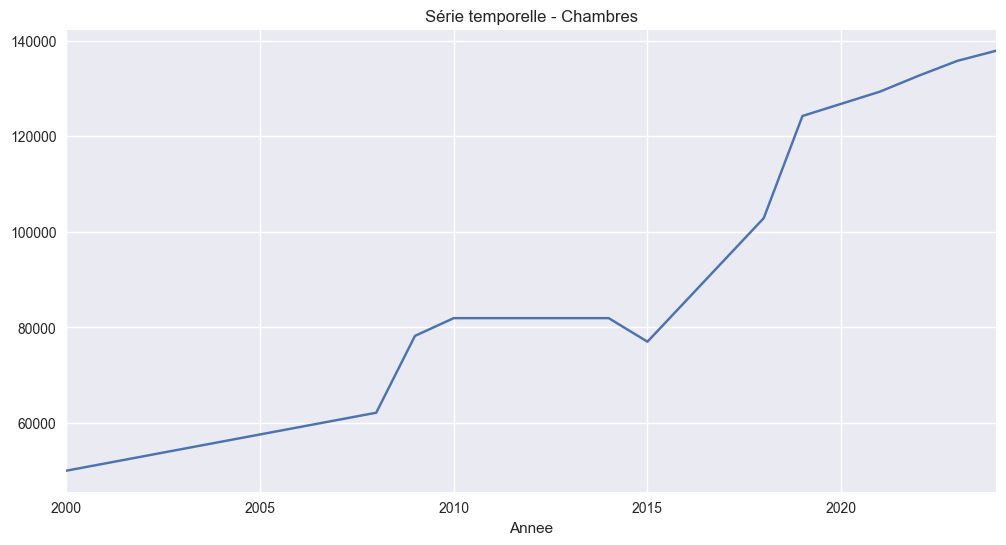

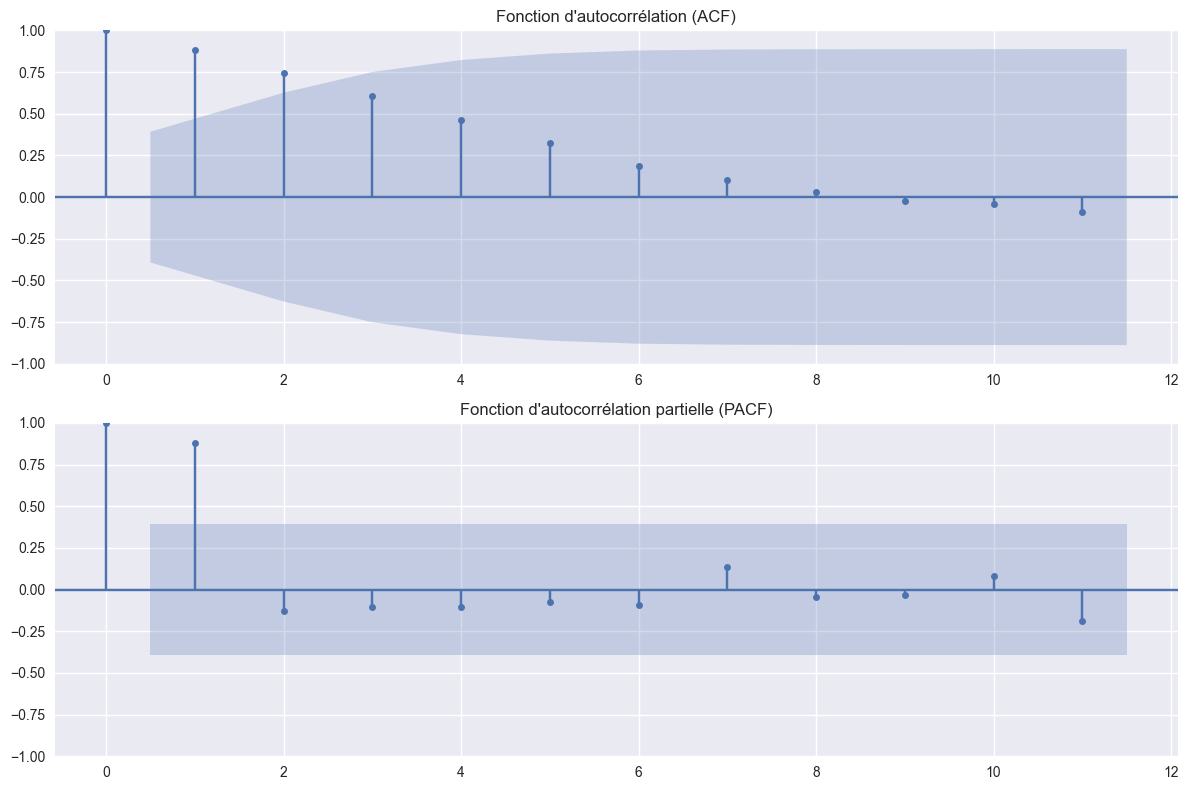

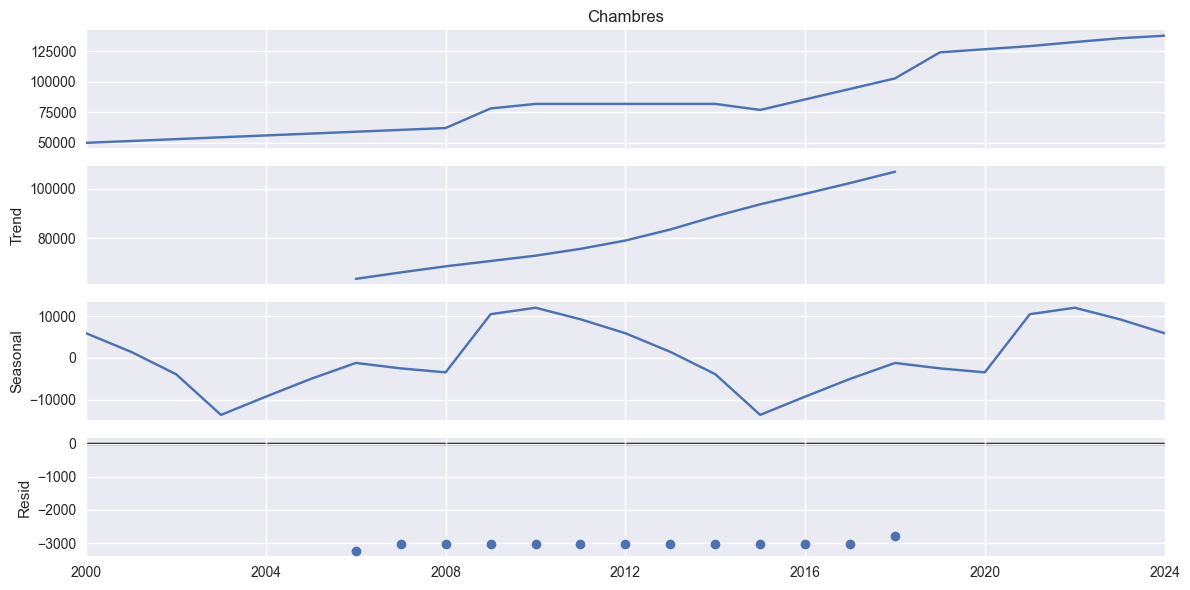

Données insuffisantes pour le test Kruskal-Wallis

=== Analyse de saisonnalité pour Hopital_Lits_total ===


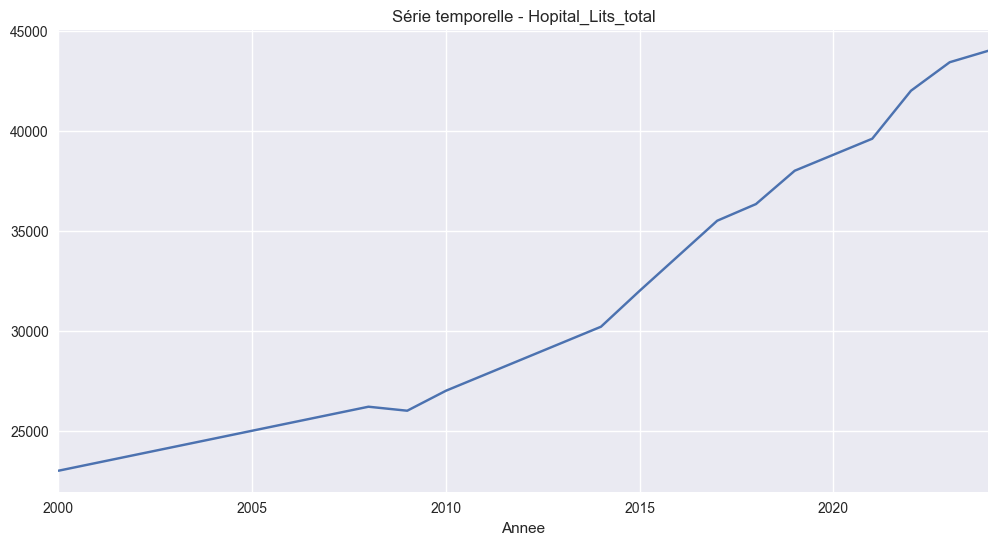

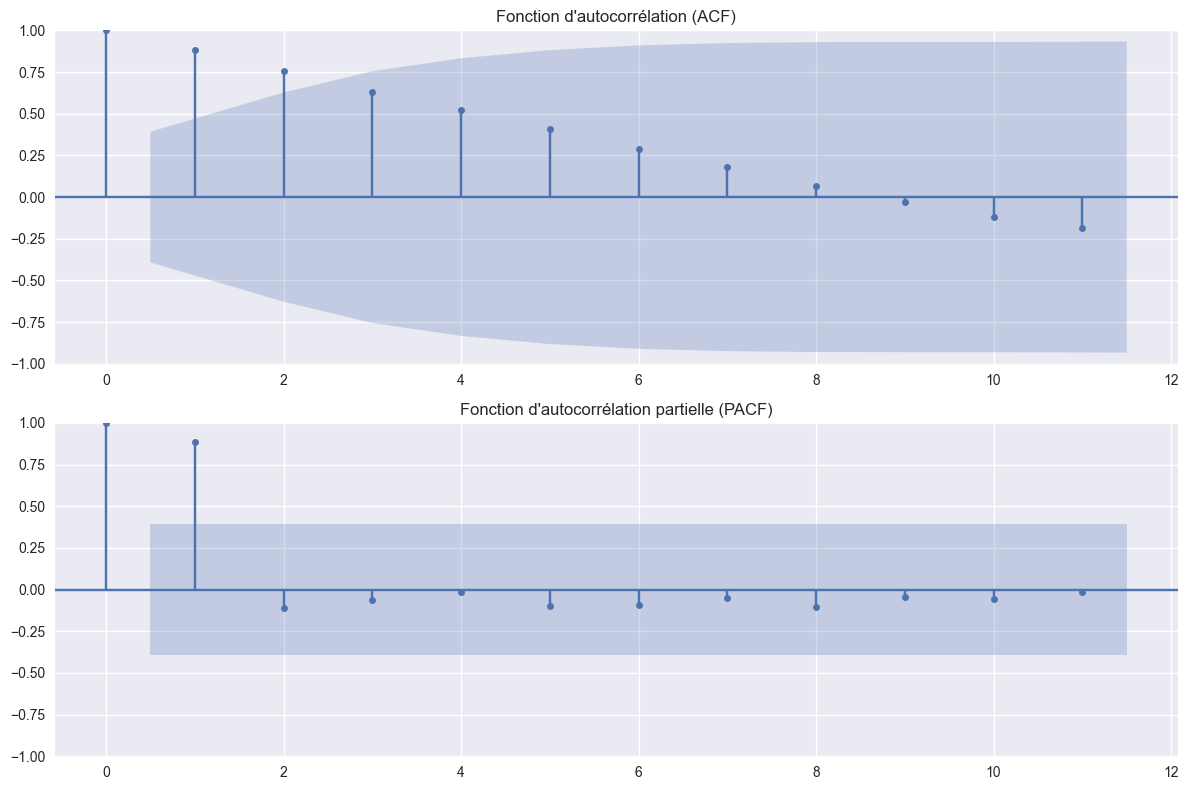

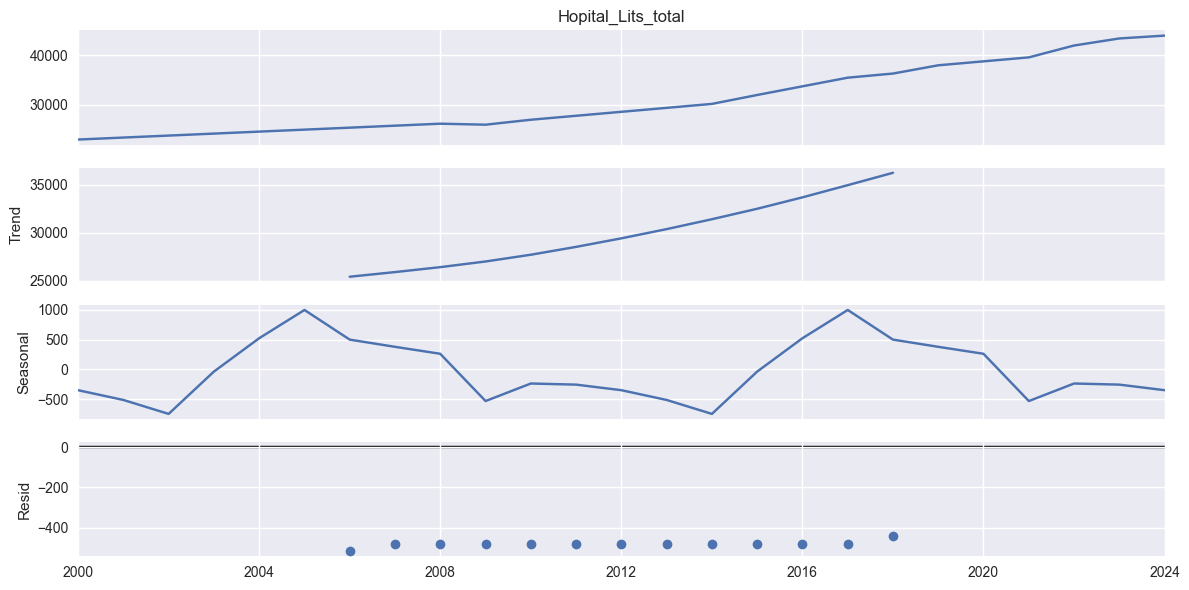

Données insuffisantes pour le test Kruskal-Wallis


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kruskal

# 1. Préparation des données
# Assurez-vous que votre DataFrame a un index de type datetime
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')
df['Annee'] = pd.to_datetime(df['Annee'], format='%Y')  # Conversion en datetime
df.set_index('Annee', inplace=True)  # Définir comme index temporel

# 2. Fonction améliorée de détection de saisonnalité
def detecter_saisonnalite(serie, freq=12, nom_serie=""):
    """Analyse complète de saisonnalité avec gestion des erreurs"""
    print(f"\n=== Analyse de saisonnalité pour {nom_serie} ===")
    
    # Vérification des données manquantes
    if serie.isnull().any():
        print("Attention: valeurs manquantes détectées - interpolation linéaire appliquée")
        serie = serie.interpolate()
    
    # A. Visualisation
    plt.figure(figsize=(12, 6))
    serie.plot(title=f'Série temporelle - {nom_serie}')
    plt.grid(True)
    plt.show()
    
    # B. ACF/PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(serie, lags=min(24, len(serie)//2-1), ax=ax1)
    ax1.set_title('Fonction d\'autocorrélation (ACF)')
    plot_pacf(serie, lags=min(24, len(serie)//2-1), ax=ax2, method='ywm')
    ax2.set_title('Fonction d\'autocorrélation partielle (PACF)')
    plt.tight_layout()
    plt.show()
    
    # C. Décomposition (seulement si suffisamment de données)
    if len(serie) > 2*freq:
        try:
            result = seasonal_decompose(serie, model='additive', period=freq)
            result.plot()
            plt.tight_layout()
            plt.show()
        except ValueError as e:
            print(f"Impossible de décomposer: {str(e)}")
    else:
        print("Trop peu de données pour la décomposition saisonnière")
    
    # D. Test statistique (Kruskal-Wallis)
    if hasattr(serie.index, 'month'):  # Vérifie si l'index a des mois
        groups = [serie[serie.index.month == month] for month in range(1, 13)]
        if all(len(g) > 0 for g in groups):  # Vérifie que tous les groupes ont des données
            _, p_value = kruskal(*groups)
            print(f"p-value (test Kruskal-Wallis): {p_value:.4f}")
            if p_value < 0.05:
                print("Conclusion: Saisonnalité significative détectée (p < 0.05)")
            else:
                print("Conclusion: Aucune saisonnalité significative")
        else:
            print("Données insuffisantes pour le test Kruskal-Wallis")
    else:
        print("Index temporel nécessaire pour le test mensuel")

# 3. Application à vos données
for colonne in ['Auto_Longueur_km', 'Chambres', 'Hopital_Lits_total']:
    detecter_saisonnalite(df[colonne], freq=12, nom_serie=colonne)

In [27]:
import numpy as np

def mape(y_true, y_pred):
    """Calcul du MAPE en pourcentage"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entraînement
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit(disp=False)

# Prévision
sarima_pred = sarima_results.get_forecast(steps=len(test_data)).predicted_mean

# Évaluation
sarima_mape = mape(test_data, sarima_pred)
print(f"MAPE SARIMA: {sarima_mape:.2f}%")

NameError: name 'train_data' is not defined

In [29]:
# Configuration de base
target_var = 'Auto_Longueur_km'
target = df[target_var]

# Séparation train/test
train_size = int(len(target) * 0.8)
train, test = target[:train_size], target[train_size:]

# Fonction MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Évite division par zéro
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# 1. SARIMA
sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarima_pred = sarima.forecast(len(test))
sarima_mape = mape(test, sarima_pred)

# 2. XGBoost (nécessite feature engineering)
def create_lags(series, lags=3):
    df = pd.DataFrame(series)
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df[target_var].shift(i)
    return df.dropna()

df_lags = create_lags(target)
X = df_lags.drop(target_var, axis=1)
y = df_lags[target_var]

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from xgboost import XGBRegressor
xgb = XGBRegressor().fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mape = mape(y_test, xgb_pred)

# 3. LSTM (implémentation simplifiée)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Préparation séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X_seq, y_seq = create_sequences(target.values, SEQ_LENGTH)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

model = Sequential([
    LSTM(16, input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(loss='mae', optimizer='adam')
model.fit(X_train_seq, y_train_seq, epochs=50, verbose=0)

lstm_pred = model.predict(X_test_seq).flatten()
lstm_mape = mape(y_test_seq, lstm_pred)

# Comparaison finale
results = pd.DataFrame({
    'Modèle': ['SARIMA', 'XGBoost', 'LSTM'],
    'MAPE (%)': [sarima_mape, xgb_mape, lstm_mape]
}).sort_values('MAPE (%)')

print(results)

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\adame\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
    Modèle    MAPE (%)
1  XGBoost    1.513391
0   SARIMA    5.589937
2     LSTM  100.000584


| Variable                | Shapiro-Wilk        | Jarque-Bera         |   Taille échantillon |
|:------------------------|:--------------------|:--------------------|---------------------:|
| Auto_Longueur_km        | 0.0449 (Non-normal) | 0.3686 (Normal)     |                   25 |
| Chambres                | 0.0059 (Non-normal) | 0.2957 (Normal)     |                   25 |
| Hopital_Lits_total      | 0.0110 (Non-normal) | 0.2684 (Normal)     |                   25 |
| Dette_%PIB              | 0.3587 (Normal)     | 0.7276 (Normal)     |                   25 |
| Croissance_PIB_%        | 0.0004 (Non-normal) | 0.0000 (Non-normal) |                   25 |
| Deficit_budgétaire_%PIB | 0.3216 (Normal)     | 0.4106 (Normal)     |                   25 |
| Chomage                 | 0.0003 (Non-normal) | 0.0218 (Non-normal) |                   25 |


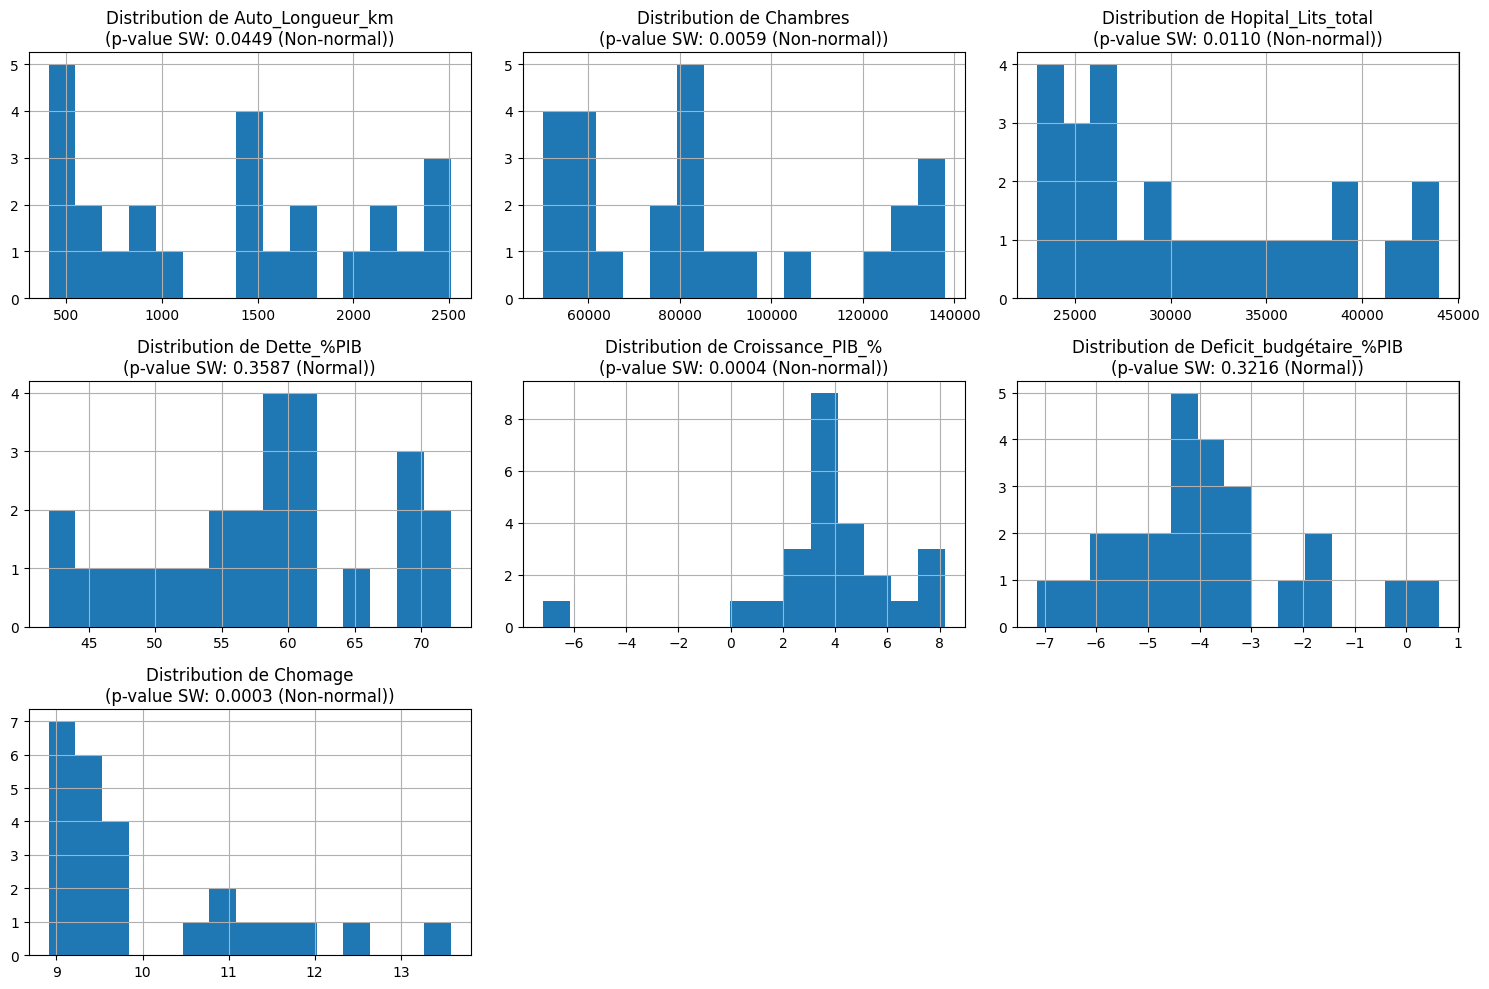

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera
import matplotlib.pyplot as plt

# 1. Chargement et nettoyage des données
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')

# Conversion des virgules en points et des chaînes en nombres
def clean_numeric(value):
    if isinstance(value, str):
        return float(value.replace(',', '.'))
    return float(value)

variables = ['Auto_Longueur_km', 'Chambres', 'Hopital_Lits_total', 
             'Dette_%PIB', 'Croissance_PIB_%', 'Deficit_budgétaire_%PIB', 'Chomage']

for var in variables:
    df[var] = df[var].apply(clean_numeric)

# 2. Fonction améliorée pour les tests
def tester_normalite(serie, nom):
    """Effectue les tests de normalité avec gestion des erreurs"""
    try:
        # Suppression des NaN et conversion en array numpy
        clean_data = serie.dropna().values
        
        # Vérification du minimum de données (Shapiro nécessite 3+ observations)
        if len(clean_data) < 3:
            return {
                'Variable': nom,
                'Shapiro-Wilk': 'N/A (n<3)',
                'Jarque-Bera': 'N/A (n<3)',
                'Normalité': 'Données insuffisantes'
            }
        
        # Test Shapiro-Wilk
        stat_sw, p_sw = shapiro(clean_data)
        
        # Test Jarque-Bera (nécessite 5+ observations)
        if len(clean_data) >= 5:
            stat_jb, p_jb = jarque_bera(clean_data)
            jb_result = f"{p_jb:.4f} {'(Normal)' if p_jb > 0.05 else '(Non-normal)'}"
        else:
            jb_result = 'N/A (n<5)'
            
        return {
            'Variable': nom,
            'Shapiro-Wilk': f"{p_sw:.4f} {'(Normal)' if p_sw > 0.05 else '(Non-normal)'}",
            'Jarque-Bera': jb_result,
            'Taille échantillon': len(clean_data)
        }
    
    except Exception as e:
        return {
            'Variable': nom,
            'Erreur': str(e)
        }

# 3. Application à toutes les variables
resultats = []
for var in variables:
    resultats.append(tester_normalite(df[var], var))

# 4. Affichage des résultats
df_resultats = pd.DataFrame(resultats)
print(df_resultats.to_markdown(index=False))

# 5. Visualisation graphique améliorée
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    df[var].hist(bins=15)
    plt.title(f'Distribution de {var}\n(p-value SW: {df_resultats.loc[i-1, "Shapiro-Wilk"]})')
plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
from scipy.stats import kruskal

# Chargement des données (exemple)
df = pd.read_excel('DB TGR.xlsx', sheet_name='BD')
df['Deficit_budgétaire_%PIB'] = df['Deficit_budgétaire_%PIB'].str.replace(',', '.').astype(float)

AttributeError: Can only use .str accessor with string values!

In [2]:
# Création des groupes
pre_2010 = df[df['Annee'] < 2010]['Chomage']
post_2010 = df[df['Annee'] >= 2010]['Chomage']

# Test Kruskal-Wallis
stat, p_value = kruskal(pre_2010, post_2010)
print(f"Statistique = {stat:.3f}, p-value = {p_value:.4f}")

# Interprétation
alpha = 0.05
if p_value < alpha:
    print("→ Rejet de H0 : différence significative entre les périodes")
else:
    print("→ Pas de différence significative")

Statistique = 8.003, p-value = 0.0047
→ Rejet de H0 : différence significative entre les périodes


In [3]:
# Groupes à comparer (exemple : variables économiques)
groups = [df['Dette_%PIB'], df['Deficit_budgétaire_%PIB'], df['Chomage']]

# Test
stat, p_value = kruskal(*groups)
print(f"\nComparaison multivariée : p-value = {p_value:.4f}")


Comparaison multivariée : p-value = 0.0000


In [4]:
from scikit_posthocs import posthoc_dunn

# Exemple avec les périodes
df['Période'] = ['Avant 2010' if x < 2010 else 'Après 2010' for x in df['Annee']]
posthoc = posthoc_dunn(df, val_col='Chomage', group_col='Période', p_adjust='holm')
print("\nTest de Dunn (ajusté de Holm):\n", posthoc)


Test de Dunn (ajusté de Holm):
             Après 2010  Avant 2010
Après 2010     1.00000     0.00467
Avant 2010     0.00467     1.00000


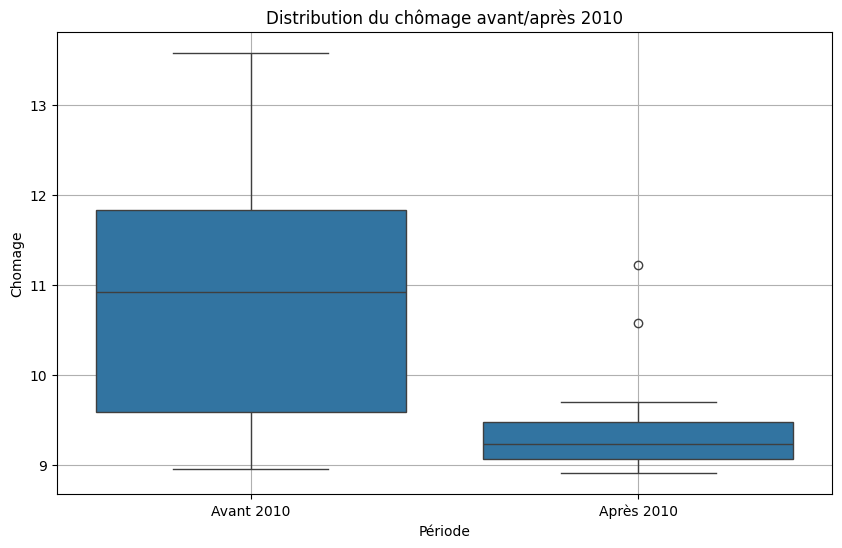

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Période', y='Chomage', data=df)
plt.title('Distribution du chômage avant/après 2010')
plt.grid(True)
plt.show()

Comparaison des longueurs d'autoroutes par période : p-value = 0.00003


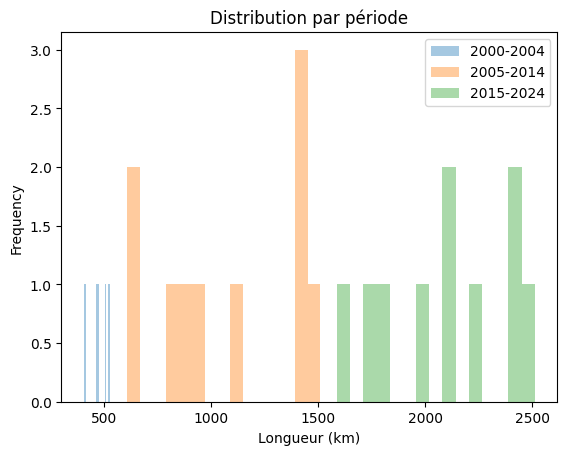

In [7]:
# Découpage en 3 périodes
import numpy as np
conditions = [
    df['Annee'] < 2005,
    (df['Annee'] >= 2005) & (df['Annee'] < 2015),
    df['Annee'] >= 2015
]
choices = ['2000-2004', '2005-2014', '2015-2024']
df['Période'] = np.select(conditions, choices)

# Test Kruskal-Wallis
stat, p = kruskal(*[group['Auto_Longueur_km'] for name, group in df.groupby('Période')])
print(f"Comparaison des longueurs d'autoroutes par période : p-value = {p:.5f}")

# Visualisation
df.groupby('Période')['Auto_Longueur_km'].plot(kind='hist', alpha=0.4, legend=True, bins=15)
plt.xlabel('Longueur (km)')
plt.title('Distribution par période')
plt.show()

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# -------- 0) Chargement & nettoyage --------
file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = pd.read_excel(file_path, sheet_name='BD')

# Nettoyage large (toutes colonnes sauf Annee)
for col in df.columns:
    if col != 'Annee':
        df[col] = (df[col].astype(str)
                             .str.replace(',', '.')
                             .str.replace(' ', '')
                             .str.replace('−', '-')
                             .str.strip())
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Enlever lignes incomplètes et indexer
df = df.dropna().copy()
df = df.set_index('Annee').sort_index()

# -------- 1) Stationnarité & différenciation automatique --------
def p_adf(s):
    s = s.dropna()
    if len(s) < 5:
        return 1.0
    return adfuller(s, autolag='AIC')[1]

df_diff = df.copy()
diffed_cols = []
for col in df.columns:
    if p_adf(df[col]) > 0.05:
        df_diff[col] = df[col].diff()
        diffed_cols.append(col)

df_diff = df_diff.dropna().copy()
print(f"Colonnes différenciées: {diffed_cols}")
print("Taille après diff:", df_diff.shape)

# -------- 2) Calcul d'un plafond de lags "estimable" --------
T = df_diff.shape[0]   # nb d'observations après diff
k = df_diff.shape[1]   # nb de variables endogènes
const = 1              # const par équation

# Heuristique : T > (k+1)*p + const  =>  p_max <= floor((T-const-1)/(k+1))
p_upper = int(np.floor((T - const - 1) / (k + 1)))
p_upper = max(1, min(p_upper, 6))   # borne supérieure prudente
print(f"Heuristique lags: T={T}, k={k}, p_upper={p_upper}")

# -------- 3) Sélection du lag optimal avec repli automatique --------
def safe_select_order(X, maxlags_start):
    model = VAR(X)
    for m in range(maxlags_start, 0, -1):
        try:
            res = model.select_order(maxlags=m)
            return res, m
        except Exception as e:
            print(f"select_order(maxlags={m}) impossible -> {e}")
            continue
    return None, 0

order_res, tried_maxlags = safe_select_order(df_diff, p_upper)

if order_res is not None:
    print(order_res.summary())
    # Choix du critère (AIC prioritaire, sinon BIC/HQIC/FPE)
    lag_opt = order_res.aic or order_res.bic or order_res.hqic or order_res.fpe
    print(f"👉 Lag optimal retenu: {lag_opt}")
    var_res = VAR(df_diff).fit(lag_opt)
    print(var_res.summary())
    print("Modèle stable ?", var_res.is_stable())

else:
    print("\n⚠️ Impossible d'estimer un VAR avec toutes les variables.")
    print("On passe à un sous-système macro plus petit.\n")

    # -------- 4) Sous-système : variables macro clés --------
    keep = ['Dette_%PIB', 'Croissance_PIB_%', 'Chomage', 'Nombre de touristes(millions)']
    keep = [c for c in keep if c in df_diff.columns]
    sub = df_diff[keep].dropna().copy()

    T2, k2 = sub.shape
    p_upper2 = int(np.floor((T2 - const - 1) / (k2 + 1)))
    p_upper2 = max(1, min(p_upper2, 6))
    print(f"Sous-système: {keep} | T={T2}, k={k2}, p_upper={p_upper2}")

    order_res2, tried_maxlags2 = safe_select_order(sub, p_upper2)
    if order_res2 is None:
        raise RuntimeError("Même le sous-système ne permet pas la sélection des lags. Réduire encore k ou étendre T.")
    print(order_res2.summary())

    lag_opt2 = order_res2.aic or order_res2.bic or order_res2.hqic or order_res2.fpe
    print(f"👉 Lag optimal (sous-système): {lag_opt2}")

    var_res2 = VAR(sub).fit(lag_opt2)
    print(var_res2.summary())
    print("Modèle stable ?", var_res2.is_stable())

    # IRF & FEVD (facultatif, utiles pour le rapport)
    # irf = var_res2.irf(10); irf.plot(orth=True)
    # fevd = var_res2.fevd(10); fevd.plot()


Colonnes différenciées: ['Auto_Longueur_km', 'Chambres', 'Hopital_Lits_total', 'Dette_%PIB', 'Deficit_budgétaire_%PIB', 'Chomage', 'Score GPI']
Taille après diff: (24, 9)
Heuristique lags: T=24, k=9, p_upper=2
select_order(maxlags=2) impossible -> maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       37.22      37.66*   1.461e+16       37.33
1      35.40*       39.84  4.115e+15*      36.51*
-------------------------------------------------
👉 Lag optimal retenu: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Aug, 2025
Time:                     14:34:04
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    39.

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\adame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



Colonnes différenciées : ['Auto_Longueur_km', 'Chambres', 'Hopital_Lits_total', 'Dette_%PIB', 'Deficit_budgétaire_%PIB', 'Chomage', 'Score GPI']
Taille après diff : (24, 9)
Heuristique lags: T=24, k=9, maxlags_start=2
select_order(maxlags=2) impossible -> maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       37.22      37.66*   1.461e+16       37.33
1      35.40*       39.84  4.115e+15*      36.51*
-------------------------------------------------
👉 Lag optimal retenu : 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Aug, 2025
Time:                     14:34:11
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:              

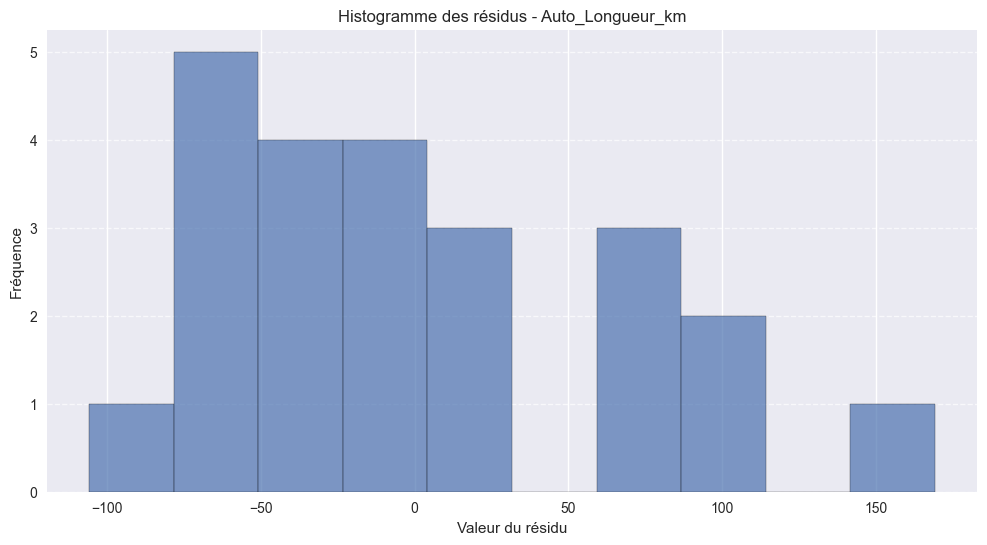

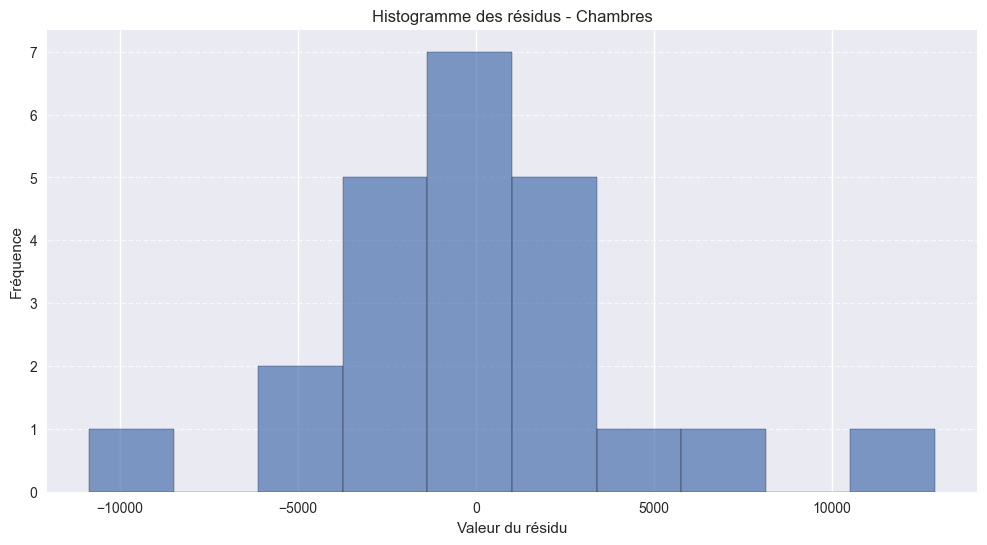

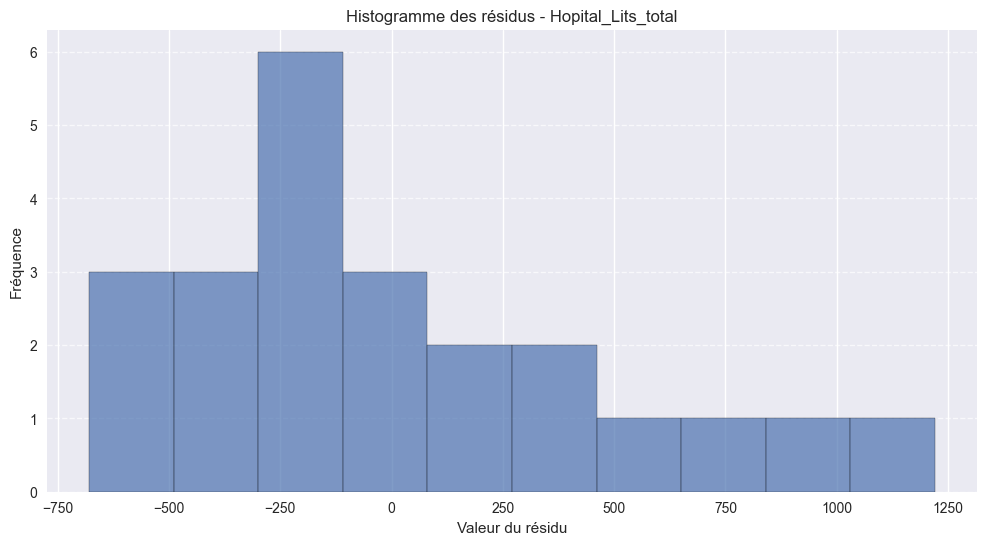

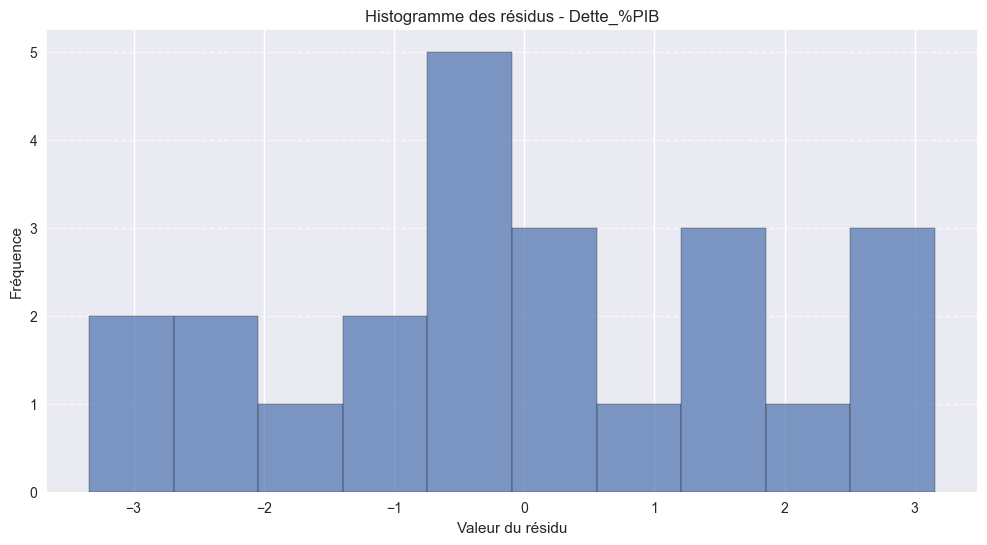

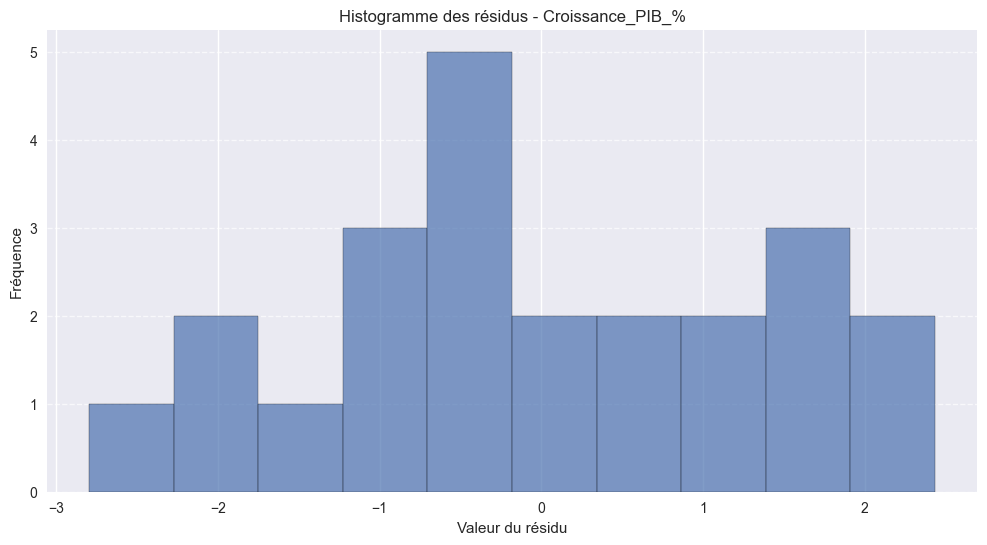

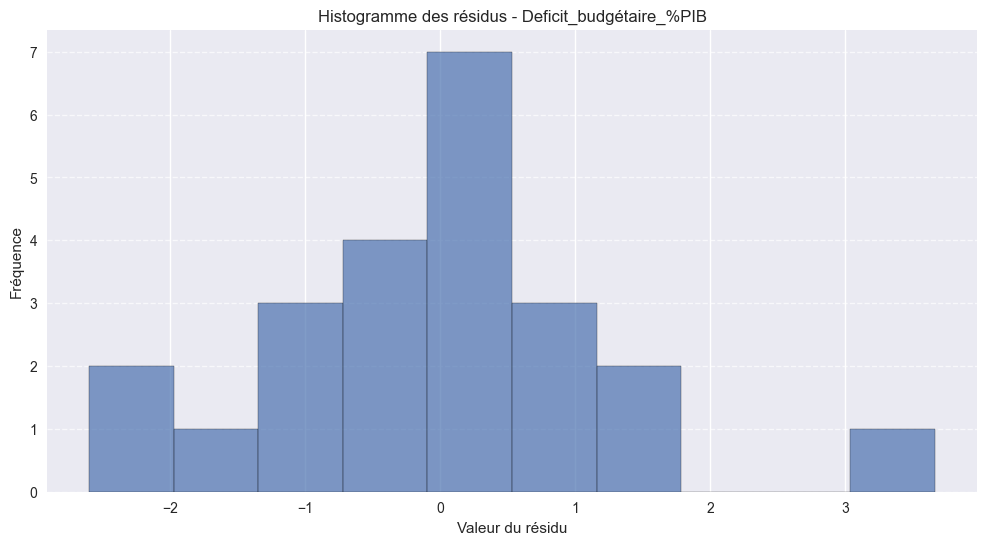

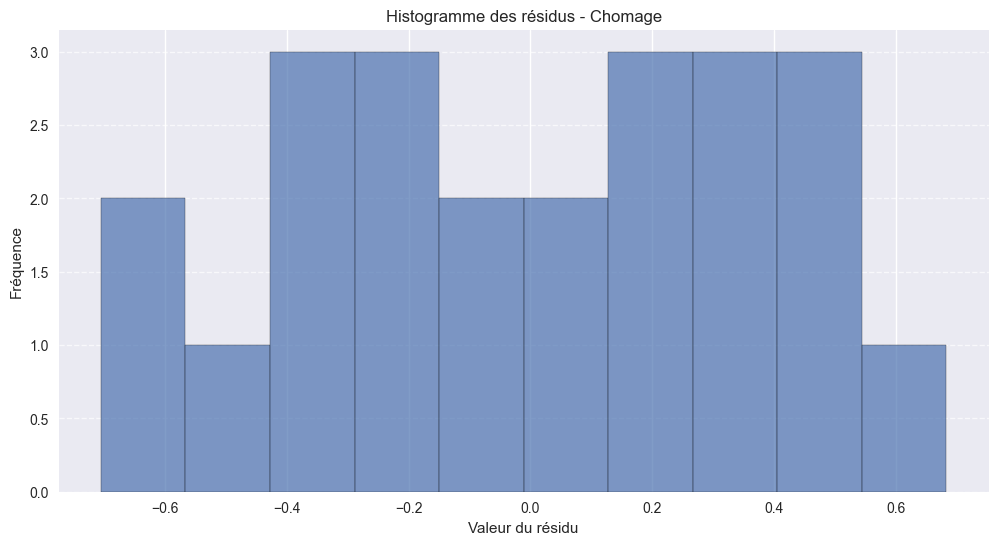

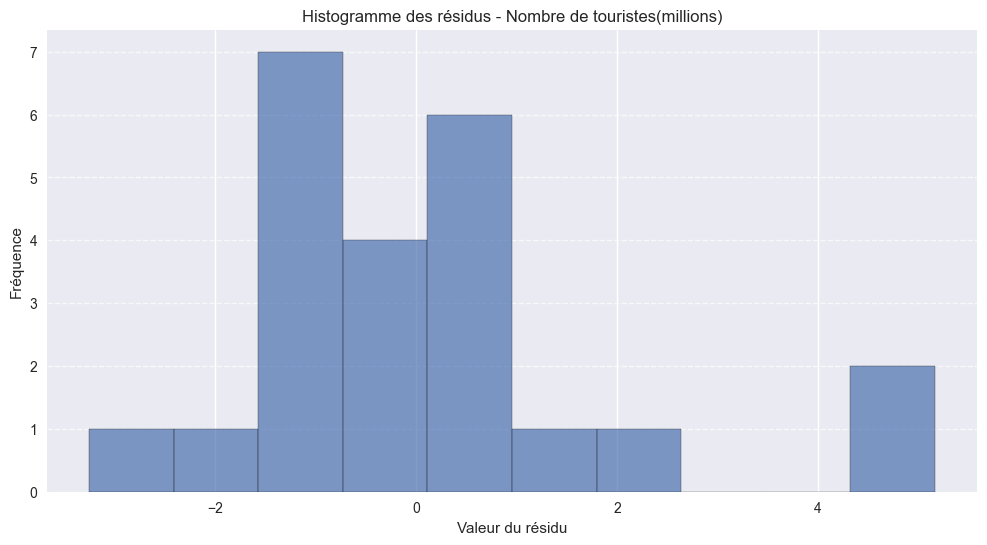

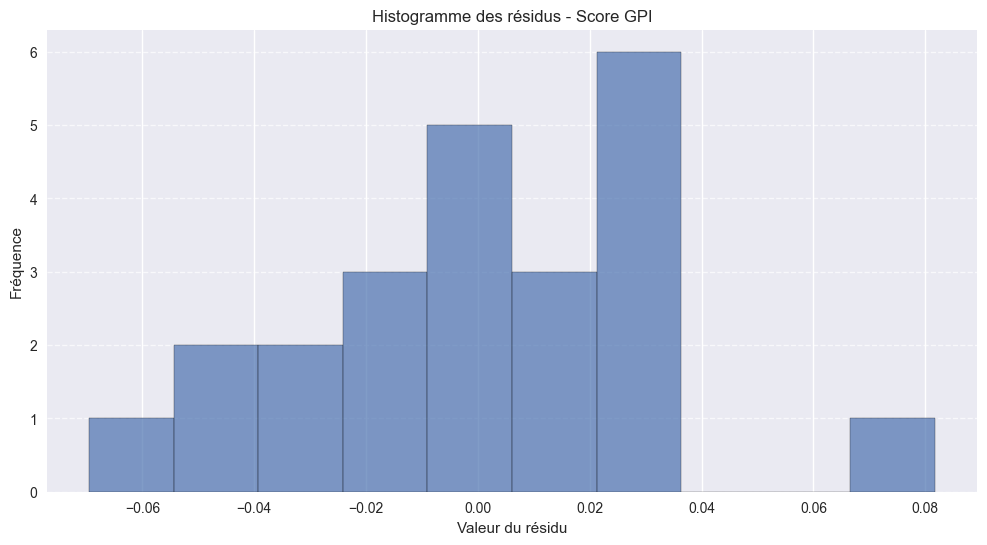


Résumé normalité (Jarque–Bera) sur résidus :
                        Variable   JB_stat   p_value  Skewness  Kurtosis
7  Nombre de touristes(millions)  7.961402  0.018673  1.237024  4.478729
1                       Chambres  3.696589  0.157506  0.460317  4.734861
2             Hopital_Lits_total  3.007178  0.222331  0.885701  3.007661
5        Deficit_budgétaire_%PIB  2.709924  0.257957  0.470231  4.394015
0               Auto_Longueur_km  2.222689  0.329116  0.759887  2.901943
6                        Chomage  0.968545  0.616145 -0.048851  1.999445
3                     Dette_%PIB  0.824291  0.662228  0.087007  2.089040
4               Croissance_PIB_%  0.529667  0.767334 -0.003634  2.256601
8                      Score GPI  0.205156  0.902508  0.131605  3.380521


In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import os

# ============ 1) CHARGER & NETTOYER ============
def load_and_clean(path, sheet='BD'):
    df = pd.read_excel(path, sheet_name=sheet)

    # Harmoniser les colonnes numériques (virgules -> points, espaces -> rien)
    for col in df.columns:
        if col != 'Annee':
            df[col] = (df[col].astype(str)
                                 .str.replace(',', '.', regex=False)
                                 .str.replace(' ', '', regex=False)
                                 .str.replace('−', '-', regex=False)
                                 .str.strip())
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Index annuel (PeriodIndex) pour éviter les warnings "unsupported index"
    df['Annee'] = pd.to_numeric(df['Annee'], errors='coerce').astype('Int64')
    df = df.dropna().copy()
    df = df.set_index('Annee').sort_index()
    df.index = pd.PeriodIndex(df.index.astype(int), freq='Y')
    return df

file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = load_and_clean(file_path)

# ============ 2) STATIONNARISER (ADF + diff si nécessaire) ============
def p_adf(series):
    s = series.dropna()
    if len(s) < 6:   # échantillon trop court -> p-value élevée par prudence
        return 1.0
    return adfuller(s, autolag='AIC')[1]

df_diff = df.copy()
diffed_cols = []
for col in df.columns:
    if p_adf(df[col]) > 0.05:
        df_diff[col] = df[col].diff()
        diffed_cols.append(col)

df_diff = df_diff.dropna().copy()
print("Colonnes différenciées :", diffed_cols)
print("Taille après diff :", df_diff.shape)

# ============ 3) CHOIX DU NOMBRE DE LAGS (robuste) ============
def safe_maxlags(T, k, cap=6):
    # Heuristique prudente : p_max <= floor((T - const - 1)/(k + 1))
    const = 1
    p_up = int(np.floor((T - const - 1) / (k + 1)))
    p_up = max(1, min(p_up, cap))
    return p_up

T, k = df_diff.shape
maxlags_start = safe_maxlags(T, k, cap=6)
print(f"Heuristique lags: T={T}, k={k}, maxlags_start={maxlags_start}")

def try_select_order(X, maxlags_start):
    model = VAR(X)
    for m in range(maxlags_start, 0, -1):
        try:
            res = model.select_order(maxlags=m)
            return res, m
        except Exception as e:
            print(f"select_order(maxlags={m}) impossible -> {e}")
            continue
    return None, 0

order_res, tried_max = try_select_order(df_diff, maxlags_start)

if order_res is None:
    raise RuntimeError("Impossible d'estimer un VAR avec toutes les variables. "
                       "Réduis le nombre de variables (sous-système).")

print(order_res.summary())

# Choix du lag par AIC prioritaire, sinon BIC/HQIC/FPE
lag_opt = order_res.aic or order_res.bic or order_res.hqic or order_res.fpe
lag_opt = int(lag_opt)  # s'assurer que c'est bien un entier
print("👉 Lag optimal retenu :", lag_opt)

# ============ 4) ESTIMATION VAR ============
var_model = VAR(df_diff)
results = var_model.fit(lag_opt)
print(results.summary())
print("Modèle stable ?", results.is_stable())

# ============ 5) HISTOGRAMMES DES RÉSIDUS + TESTS ============

residuals = results.resid  # DataFrame (mêmes colonnes que df_diff)
os.makedirs("residual_plots", exist_ok=True)

jb_table = []  # pour stocker les résultats Jarque–Bera

for col in residuals.columns:
    # Histogramme
    plt.figure()
    plt.hist(residuals[col].dropna(), bins=10, edgecolor='black', alpha=0.7)
    plt.title(f"Histogramme des résidus - {col}")
    plt.xlabel("Valeur du résidu")
    plt.ylabel("Fréquence")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"residual_plots/hist_residus_{col}.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Test de normalité Jarque–Bera
    jb_stat, jb_pvalue, skew, kurt = jarque_bera(residuals[col].dropna())
    jb_table.append({
        "Variable": col,
        "JB_stat": jb_stat,
        "p_value": jb_pvalue,
        "Skewness": skew,
        "Kurtosis": kurt
    })

jb_df = pd.DataFrame(jb_table)
print("\nRésumé normalité (Jarque–Bera) sur résidus :")
print(jb_df.sort_values("p_value"))

# Option : sauvegarder le tableau pour le rapport
jb_df.to_excel("residual_plots/JarqueBera_Residus_VAR.xlsx", index=False)


In [33]:
# ==============================
# PIPELINE ÉVALUATION COMPLÈTE
# ARIMA/SARIMA | VAR | XGBOOST
# ==============================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# -- Imports optionnels (le script s'adapte si absents)
try:
    import pmdarima as pm
    HAVE_PM = True
except Exception:
    HAVE_PM = False

from statsmodels.tsa.api import VAR

try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False


# ---------- Métriques ----------
def mape_safe(y_true, y_pred, eps=1e-8, ignore_zeros=True):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if ignore_zeros:
        mask = np.abs(y_true) > eps
        y_true, y_pred = y_true[mask], y_pred[mask]
        if y_true.size == 0:
            return np.nan
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return float(np.nanmean(np.abs((y_true - y_pred)/denom)) * 100.0)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.nanmean((y_true - y_pred)**2)))


# ---------- Utils data ----------
def safe_numeric_cleanup(df, year_col='Annee'):
    """Nettoyage numérique + index année (int)."""
    df = df.copy()
    for c in df.columns:
        if c != year_col:
            df[c] = (df[c].astype(str)
                             .str.replace(',', '.', regex=False)
                             .str.replace(' ', '', regex=False)
                             .str.replace('−', '-', regex=False)
                             .str.strip())
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=[year_col]).copy()
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
    df = df.set_index(year_col).sort_index()
    return df

def train_test_split_by_year(df, test_years=5):
    years = np.array(df.index.astype(int))
    uniq = np.sort(np.unique(years))
    if len(uniq) <= test_years:
        raise ValueError("Pas assez d'années pour un split train/test. Réduire test_years.")
    cut = uniq[-test_years]
    df_train = df[years < cut].copy()
    df_test  = df[years >= cut].copy()
    return df_train, df_test


# ---------- ARIMA/SARIMA ----------
def forecast_arima_auto(y_train, h, seasonal=False, m=1):
    """Prévision h pas via auto_arima si dispo, sinon naïf."""
    if HAVE_PM:
        try:
            model = pm.auto_arima(
                y_train, seasonal=seasonal, m=m,
                stepwise=True, suppress_warnings=True, error_action="ignore"
            )
            fc = model.predict(n_periods=h)
            return np.asarray(fc, dtype=float)
        except Exception:
            pass
    return np.repeat(float(y_train.iloc[-1]), h)


# ---------- VAR ----------
def safe_maxlags(T, k, cap=4):
    const = 1
    p_up = int(np.floor((T - const - 1) / (k + 1)))
    return max(1, min(p_up, cap))

def forecast_var(df_train, h):
    T, k = df_train.shape
    p_up = safe_maxlags(T, k, cap=4)
    model = VAR(df_train)
    for m in range(p_up, 0, -1):
        try:
            sel = model.select_order(maxlags=m)
            lag_opt = sel.aic or sel.bic or sel.hqic or sel.fpe
            lag_opt = int(lag_opt)
            res = model.fit(lag_opt)
            fc = res.forecast(df_train.values[-lag_opt:], steps=h)
            return fc, list(df_train.columns), lag_opt
        except Exception:
            continue
    last_row = df_train.values[-1, :]
    fc = np.tile(last_row, (h, 1))
    return fc, list(df_train.columns), 0


# ---------- XGBoost (lags) ----------
def make_lag_features(y, max_lag=3):
    data = {}
    for L in range(1, max_lag+1):
        data[f"lag_{L}"] = y.shift(L)
    return pd.DataFrame(data, index=y.index)

def forecast_xgb(y, y_train_end_index, y_test_index, max_lag=3):
    if not HAVE_XGB:
        last_val = float(y.loc[y_train_end_index].iloc[-1] if hasattr(y_train_end_index, '__len__') else y.iloc[-1])
        return np.repeat(last_val, len(y_test_index))

    X = make_lag_features(y, max_lag=max_lag)
    df_feat = pd.concat([y.rename("y"), X], axis=1)

    train_mask = df_feat.index <= y_train_end_index.max()
    test_mask  = df_feat.index.isin(y_test_index)

    train = df_feat.loc[train_mask].dropna()
    test  = df_feat.loc[test_mask]

    if train.empty or test.empty:
        last_val = float(y.loc[y_train_end_index].iloc[-1] if hasattr(y_train_end_index, '__len__') else y.iloc[-1])
        return np.repeat(last_val, len(y_test_index))

    X_train, y_train = train.drop(columns=["y"]), train["y"]
    X_test  = test.drop(columns=["y"])

    model = XGBRegressor(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_alpha=0.0, reg_lambda=1.0,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.asarray(y_pred, dtype=float)


# ---------- PIPELINE ----------
def eval_all_models_on_indicators(df, test_years=5, seasonal_map=None):
    if seasonal_map is None:
        seasonal_map = {}

    df_train, df_test = train_test_split_by_year(df, test_years=test_years)
    test_idx = df_test.index

    metrics_rows = []
    preds_dict = {}

    # ARIMA/SARIMA (univarié)
    for col in df.columns:
        y_train = df_train[col].dropna()
        y_test  = df_test[col].dropna()
        if y_train.empty or y_test.empty:
            continue
        seas, m = seasonal_map.get(col, (False, 1))
        y_hat = forecast_arima_auto(y_train, h=len(y_test), seasonal=seas, m=m)
        y_hat_s = pd.Series(y_hat, index=y_test.index)
        metrics_rows.append({
            "Modèle": "ARIMA/SARIMA",
            "Indicateur": col,
            "RMSE": rmse(y_test.values, y_hat_s.values),
            "MAPE(%)": mape_safe(y_test.values, y_hat_s.values),
            "N_test": len(y_test)
        })
        preds_dict[("ARIMA/SARIMA", col)] = pd.DataFrame({
            "Annee": y_test.index.astype(int),
            "y_true": y_test.values, "y_pred": y_hat_s.values
        })

    # VAR (multivarié)
    try:
        cols_ok = [c for c in df.columns if df_train[c].notna().sum() > 5 and df_test[c].notna().sum() > 0]
        df_tr_sub = df_train[cols_ok].dropna()
        if df_tr_sub.shape[0] >= 10 and df_tr_sub.shape[1] >= 2:
            fc_mat, var_cols, lag_opt = forecast_var(df_tr_sub, h=len(test_idx))
            fc_df = pd.DataFrame(fc_mat, index=test_idx, columns=var_cols)
            for col in var_cols:
                y_test = df_test[col].reindex(test_idx).dropna()
                y_hat  = fc_df[col].reindex(y_test.index)
                if len(y_hat) == len(y_test):
                    metrics_rows.append({
                        "Modèle": f"VAR(p={lag_opt})",
                        "Indicateur": col,
                        "RMSE": rmse(y_test.values, y_hat.values),
                        "MAPE(%)": mape_safe(y_test.values, y_hat.values),
                        "N_test": len(y_test)
                    })
                    preds_dict[(f"VAR(p={lag_opt})", col)] = pd.DataFrame({
                        "Annee": y_test.index.astype(int),
                        "y_true": y_test.values, "y_pred": y_hat.values
                    })
    except Exception:
        pass

    # XGBoost (univarié, lags)
    for col in df.columns:
        y = df[col].copy()
        if y.loc[df_train.index].dropna().shape[0] < 6 or y.loc[df_test.index].dropna().shape[0] < 1:
            continue
        try:
            y_pred = forecast_xgb(y, y_train_end_index=df_train.index, y_test_index=df_test.index, max_lag=3)
            y_test = y.loc[df_test.index].values.astype(float)
            if len(y_pred) == len(y_test):
                metrics_rows.append({
                    "Modèle": "XGBOOST",
                    "Indicateur": col,
                    "RMSE": rmse(y_test, y_pred),
                    "MAPE(%)": mape_safe(y_test, y_pred),
                    "N_test": len(y_test)
                })
                preds_dict[("XGBOOST", col)] = pd.DataFrame({
                    "Annee": df_test.index.astype(int),
                    "y_true": y_test, "y_pred": y_pred
                })
        except Exception:
            pass

    metrics_df = pd.DataFrame(metrics_rows).sort_values(["Indicateur", "MAPE(%)"]).reset_index(drop=True)
    return metrics_df, preds_dict


# ---------- Exécution ----------
if __name__ == "__main__":
    # Chemin & feuille
    FILE  = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
    SHEET = "BD"

    # Charger & nettoyer
    raw = pd.read_excel(FILE, sheet_name=SHEET)
    df  = safe_numeric_cleanup(raw, year_col="Annee")

    # Séries saisonnières identifiées (s=5 pluriannuel d'après ta sélection)
    seasonal_map = {
        "Nombre de touristes(millions)": (True, 5),
        "Croissance_PIB_%": (True, 5),
        "Chomage": (True, 5),
        "Dette_%PIB": (True, 5),
        # Tu peux en ajouter/retirer ici
    }

    # Évaluation (5 dernières années en test)
    metrics_df, preds_dict = eval_all_models_on_indicators(
        df, test_years=5, seasonal_map=seasonal_map
    )

    # Affichage
    pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
    print("\n=== RÉSUMÉ DES MÉTRIQUES (par Modèle x Indicateur) ===")
    print(metrics_df.to_string(index=False))

    best = metrics_df.sort_values(["Indicateur", "MAPE(%)"]).groupby("Indicateur").head(1)
    print("\n=== MEILLEUR MODÈLE PAR INDICATEUR (critère: MAPE) ===")
    print(best[["Indicateur", "Modèle", "MAPE(%)", "RMSE", "N_test"]].to_string(index=False))

    # (Option) Sauvegarde
    # metrics_df.to_excel("results_metrics.xlsx", index=False)
    # for (model, indic), dfp in preds_dict.items():
    #     dfp.to_excel(f"preds_{model}_{indic}.xlsx".replace("%","pct"), index=False)



=== RÉSUMÉ DES MÉTRIQUES (par Modèle x Indicateur) ===
      Modèle                    Indicateur       RMSE  MAPE(%)  N_test
ARIMA/SARIMA              Auto_Longueur_km     60.357    2.485       5
     XGBOOST              Auto_Longueur_km    269.920    9.433       5
    VAR(p=1)              Auto_Longueur_km  1,161.533   40.784       5
ARIMA/SARIMA                      Chambres  3,778.762    2.587       5
     XGBOOST                      Chambres  9,209.732    6.150       5
    VAR(p=1)                      Chambres 35,601.846   26.831       5
     XGBOOST                       Chomage      1.064    7.337       5
ARIMA/SARIMA                       Chomage      1.335   11.058       5
    VAR(p=1)                       Chomage      1.829   15.984       5
     XGBOOST              Croissance_PIB_%      5.509   74.232       5
ARIMA/SARIMA              Croissance_PIB_%      6.851  115.291       5
    VAR(p=1)              Croissance_PIB_%      5.320  160.829       5
     XGBOOST       De

In [35]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Exemple avec Auto_Longueur_km
serie = df["Auto_Longueur_km"]

# Auto-arima pour trouver p,d,q optimaux
auto_model = pm.auto_arima(serie, seasonal=False, stepwise=True, suppress_warnings=True)
print("Paramètres optimaux (p,d,q):", auto_model.order)

# Construire ARIMA avec ces paramètres
model = ARIMA(serie, order=auto_model.order)
fit = model.fit()

# Prévision 5 périodes
forecast = fit.forecast(steps=5)
print("Prévisions Auto_Longueur_km:", forecast)



Paramètres optimaux (p,d,q): (0, 1, 0)
Prévisions Auto_Longueur_km: 25   2,511.000
26   2,511.000
27   2,511.000
28   2,511.000
29   2,511.000
Name: predicted_mean, dtype: float64


⇒ Auto_Longueur_km: ordre ARIMA optimal (p,d,q) = (0, 1, 0)


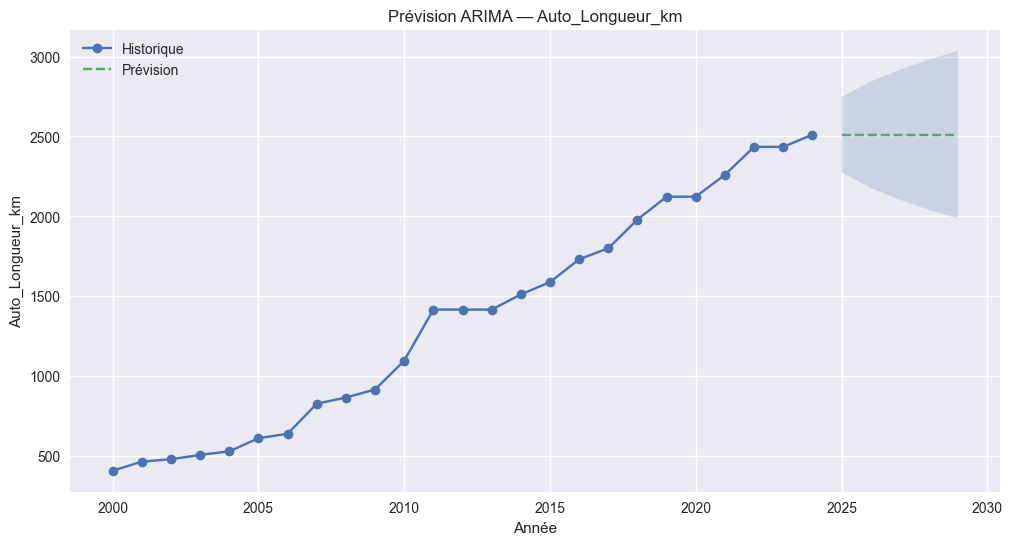

⇒ Chambres: ordre ARIMA optimal (p,d,q) = (0, 1, 0)


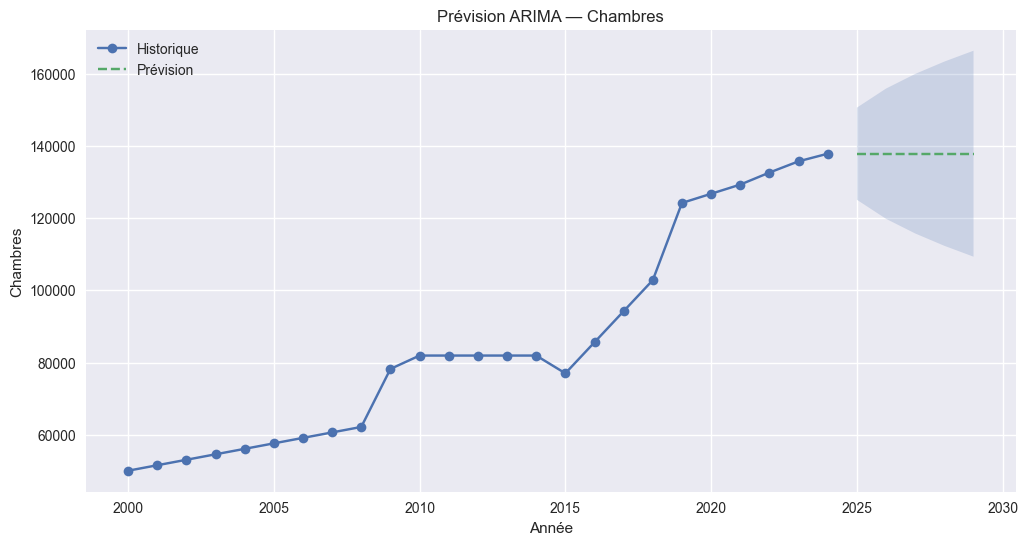

⇒ Hopital_Lits_total: ordre ARIMA optimal (p,d,q) = (0, 2, 0)


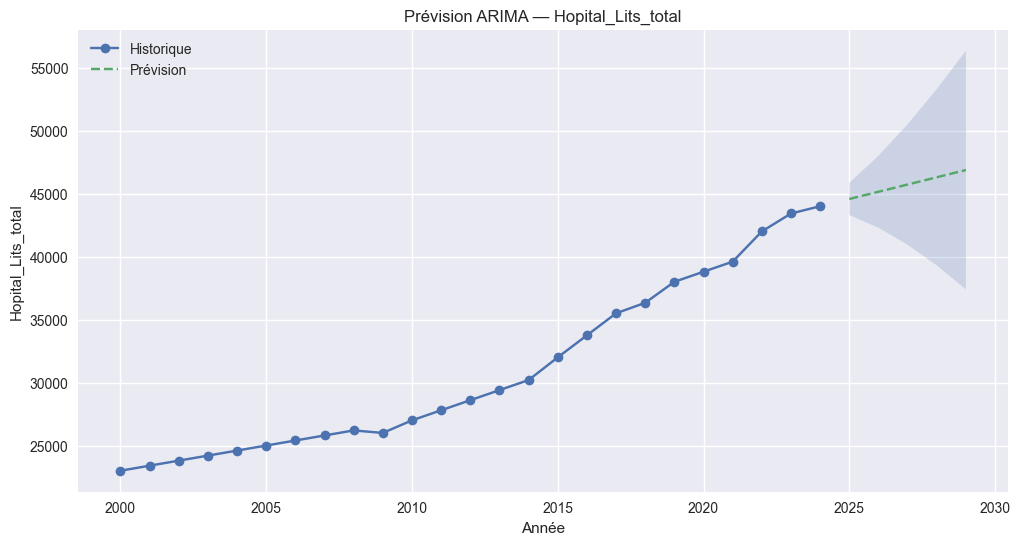

⇒ Score GPI: ordre ARIMA optimal (p,d,q) = (0, 0, 0)


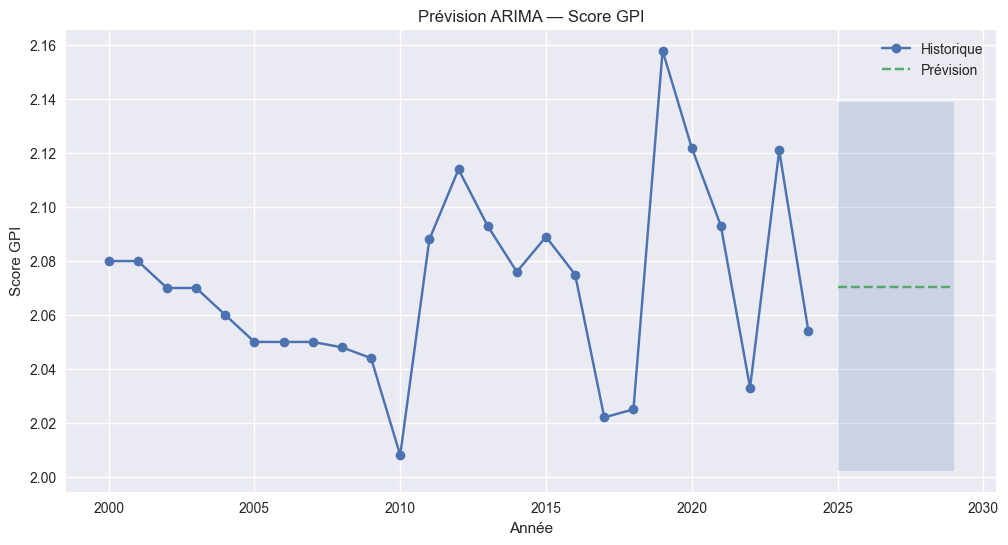


=== PRÉVISIONS (5 ans) — ARIMA ===
       Auto_Longueur_km_pred  Auto_Longueur_km_ci_low  Auto_Longueur_km_ci_high  Chambres_pred  Chambres_ci_low  Chambres_ci_high  Hopital_Lits_total_pred  Hopital_Lits_total_ci_low  Hopital_Lits_total_ci_high  Score GPI_pred  Score GPI_ci_low  Score GPI_ci_high
Annee                                                                                                                                                                                                                                                                 
2025               2,511.000                2,275.738                 2,746.262    137,886.000      125,118.977       150,653.023               44,575.000                 43,297.609                  45,852.391           2.071             2.002              2.139
2026               2,511.000                2,178.289                 2,843.711    137,886.000      119,830.702       155,941.298               45,150.000                 42,2

In [37]:
# ===========================================
# ARIMA auto + PRÉVISIONS + PLOTS (4 séries)
# ===========================================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
try:
    import pmdarima as pm
    HAVE_PM = True
except Exception:
    HAVE_PM = False

# ---- 1) Charger & nettoyer ----
FILE  = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
SHEET = "BD"

def load_clean(path, sheet="BD", year_col="Annee"):
    df = pd.read_excel(path, sheet_name=sheet)
    for c in df.columns:
        if c != year_col:
            df[c] = (df[c].astype(str)
                              .str.replace(',', '.', regex=False)
                              .str.replace(' ', '', regex=False)
                              .str.replace('−', '-', regex=False)
                              .str.strip())
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=[year_col]).copy()
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
    df = df.set_index(year_col).sort_index()
    return df

df = load_clean(FILE, SHEET)

# ---- 2) Paramètres ----
indicateurs_arima = [
    "Auto_Longueur_km",
    "Chambres",
    "Hopital_Lits_total",
    "Score GPI"
]
N_FUTURE = 5  # années à prévoir
out_dir = "arima_plots"

import os
os.makedirs(out_dir, exist_ok=True)

# ---- 3) Fonction générique ARIMA + plot ----
def fit_forecast_plot_arima(series, n_future=5, title=None, savepath=None):
    """
    series: pd.Series (index: années int)
    n_future: nb de pas futurs (années)
    """
    series = series.dropna()
    if series.empty or series.shape[0] < 6:
        print(f"⛔ Série trop courte pour ARIMA: {series.name}")
        return None

    # auto_arima pour (p,d,q)
    if HAVE_PM:
        try:
            auto = pm.auto_arima(series, seasonal=False, stepwise=True,
                                 suppress_warnings=True, error_action="ignore")
            order = auto.order
        except Exception:
            order = (0,1,0)
    else:
        order = (0,1,0)

    print(f"⇒ {series.name}: ordre ARIMA optimal (p,d,q) = {order}")

    # fit statsmodels
    model = ARIMA(series, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit()

    # prévisions + IC
    fc_res = res.get_forecast(steps=n_future)
    fc_mean = fc_res.predicted_mean
    fc_ci   = fc_res.conf_int(alpha=0.05)  # 95%

    # index futur (années)
    last_year = int(series.index.astype(int).max())
    future_index = pd.Index([last_year + i for i in range(1, n_future + 1)], name=series.index.name)
    fc_mean.index = future_index
    fc_ci.index   = future_index

    # --------- PLOT ---------
    plt.figure()
    # historique
    plt.plot(series.index.astype(int), series.values, marker="o", label="Historique")
    # prévisions
    plt.plot(future_index.astype(int), fc_mean.values, marker="x", linestyle="--", label="Prévision")
    # intervalles de confiance
    plt.fill_between(future_index.astype(int),
                     fc_ci.iloc[:, 0].values,  # lower
                     fc_ci.iloc[:, 1].values,  # upper
                     alpha=0.2)

    plt.title(title if title else f"Prévision ARIMA — {series.name}")
    plt.xlabel("Année")
    plt.ylabel(series.name)
    plt.grid(True)
    plt.legend()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

    # retour des résultats utiles
    return {
        "order": order,
        "fitted": res,
        "forecast": fc_mean,
        "conf_int": fc_ci
    }

# ---- 4) Boucle sur les 4 indicateurs ----

results = {}
for var in indicateurs_arima:
    if var not in df.columns:
        print(f"⚠️ Variable absente dans la base: {var}")
        continue
    res = fit_forecast_plot_arima(
        df[var],
        n_future=N_FUTURE,
        title=f"Prévision ARIMA — {var}",
        savepath=os.path.join(out_dir, f"ARIMA_{var.replace('%','pct').replace(' ','_')}.png")
    )
    results[var] = res


# ---- 5) (Option) Récapitulatif tabulaire des prévisions ----
# Construit un tableau "large" avec colonnes pour chaque indicateur
fc_table = pd.DataFrame(index=next(iter({k: v for k, v in results.items() if v is not None}.values()))["forecast"].index) \
            if any(v is not None for v in results.values()) else pd.DataFrame()

for var, r in results.items():
    if r is None: 
        continue
    fc_table[f"{var}_pred"] = r["forecast"].values
    fc_table[f"{var}_ci_low"]  = r["conf_int"].iloc[:, 0].values
    fc_table[f"{var}_ci_high"] = r["conf_int"].iloc[:, 1].values

if not fc_table.empty:
    print("\n=== PRÉVISIONS (5 ans) — ARIMA ===")
    print(fc_table.round(3).to_string())
    # fc_table.to_excel("ARIMA_forecasts_5ans.xlsx")


In [38]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

# Exemple pour Chômage
serie = df["Chomage"]

# Construction de features (lags)
lags = 12  # 1 an si données mensuelles
X, y = [], []
for i in range(lags, len(serie)):
    X.append(serie.iloc[i-lags:i].values)
    y.append(serie.iloc[i])
X, y = np.array(X), np.array(y)

# Entraînement
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

# Prévision future (5 pas)
last_window = serie.iloc[-lags:].values.reshape(1, -1)
preds = []
for _ in range(5):
    pred = model.predict(last_window)[0]
    preds.append(pred)
    last_window = np.roll(last_window, -1)
    last_window[0, -1] = pred

print("Prévisions Chômage:", preds)


Prévisions Chômage: [9.073131, 9.093135, 9.622811, 9.207176, 9.20013]


📊 Indicateur: Dette_%PIB
RMSE: 1.731
MAPE: 2.18%


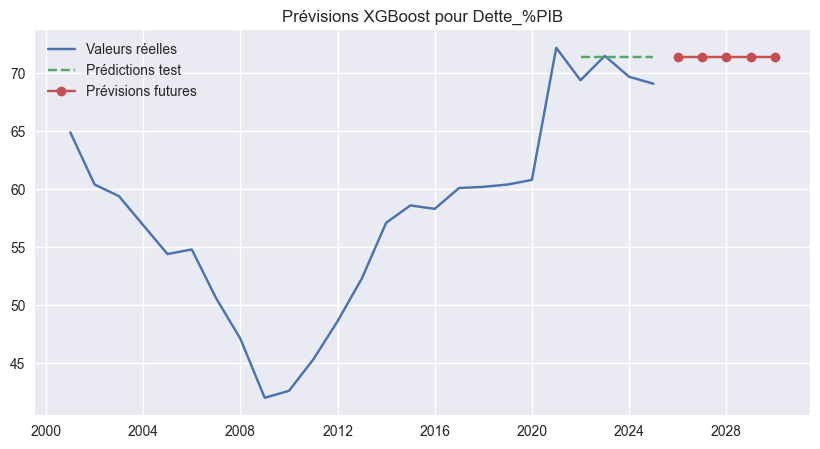

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import os

# ======================
# 1) Paramètres globaux
# ======================
N_LAGS = 5        # nombre de retards (features temporelles)
N_FUTURE = 5      # horizon de prévision (par ex. 5 ans ou 5 trimestres)
VAR = "Dette_%PIB"  # <<< Choisis l'indicateur à tester

# ======================
# 2) Charger la base
# ======================
file_path = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
df = pd.read_excel(file_path)

# Assurer un index temporel
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.date_range(start="2000", periods=len(df), freq="Y")

serie = df[VAR].dropna()

# ======================
# 3) Fonction pour créer les features (retards)
# ======================
def create_lagged_features(series, n_lags):
    data = pd.DataFrame({"y": series})
    for lag in range(1, n_lags + 1):
        data[f"lag_{lag}"] = data["y"].shift(lag)
    return data.dropna()

data = create_lagged_features(serie, N_LAGS)

# ======================
# 4) Split train/test
# ======================
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

X_train, y_train = train.drop(columns=["y"]), train["y"]
X_test, y_test = test.drop(columns=["y"]), test["y"]

# ======================
# 5) Entraînement XGBoost
# ======================
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# ======================
# 6) Prédictions sur test
# ======================
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"📊 Indicateur: {VAR}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

# ======================
# 7) Prévision future (N_FUTURE)
# ======================
last_values = list(data.iloc[-1, 1:].values)  # derniers lags
future_preds = []

for _ in range(N_FUTURE):
    X_input = np.array(last_values).reshape(1, -1)
    y_future = model.predict(X_input)[0]
    future_preds.append(y_future)

    # mettre à jour les lags
    last_values = [y_future] + last_values[:-1]

future_index = pd.date_range(start=serie.index[-1] + pd.offsets.YearEnd(),
                             periods=N_FUTURE, freq="Y")
future_series = pd.Series(future_preds, index=future_index)

# ======================
# 8) Plot
# ======================
plt.figure(figsize=(10, 5))
plt.plot(serie.index, serie, label="Valeurs réelles")
plt.plot(test.index, y_pred, label="Prédictions test", linestyle="--")
plt.plot(future_series.index, future_series, label="Prévisions futures", marker="o")
plt.title(f"Prévisions XGBoost pour {VAR}")
plt.legend()
plt.grid(True)
plt.show()


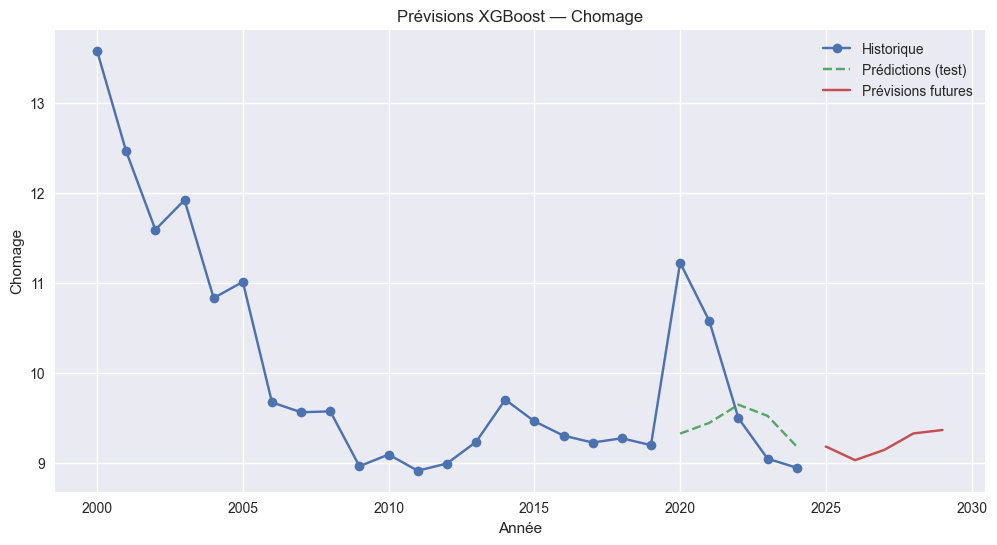

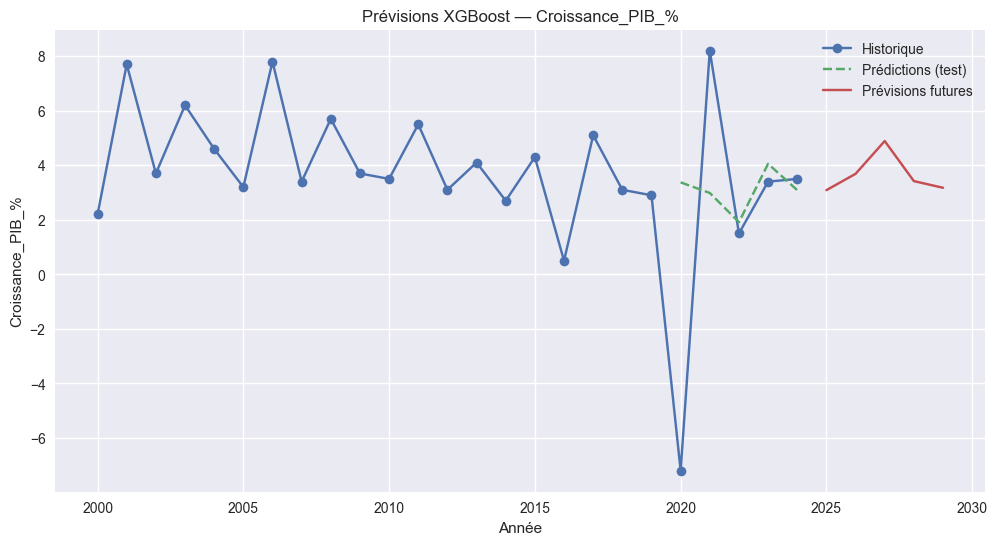

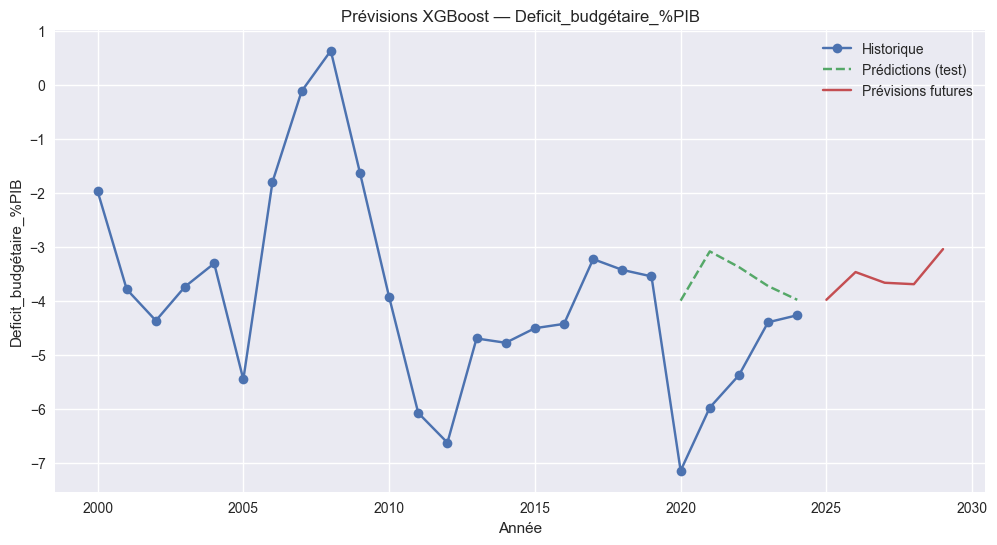

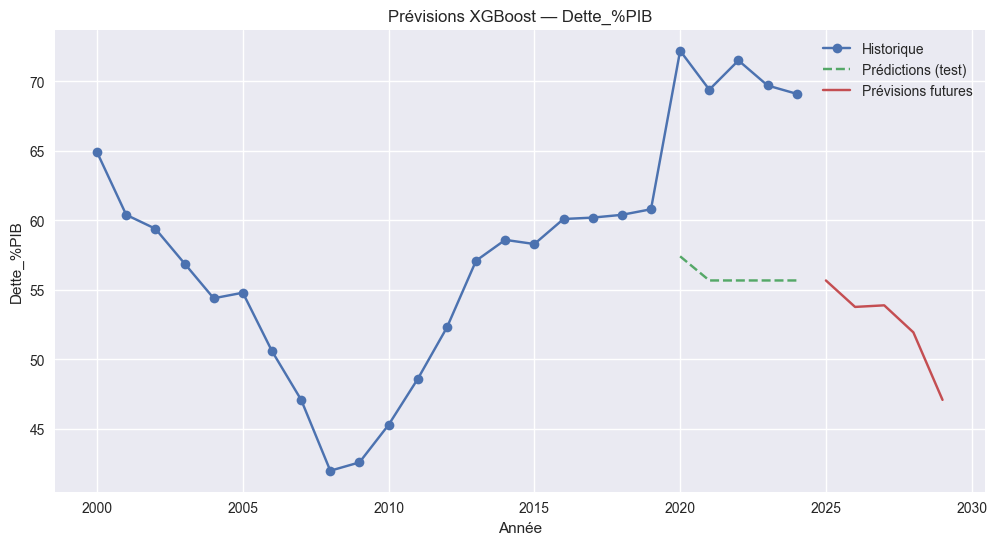

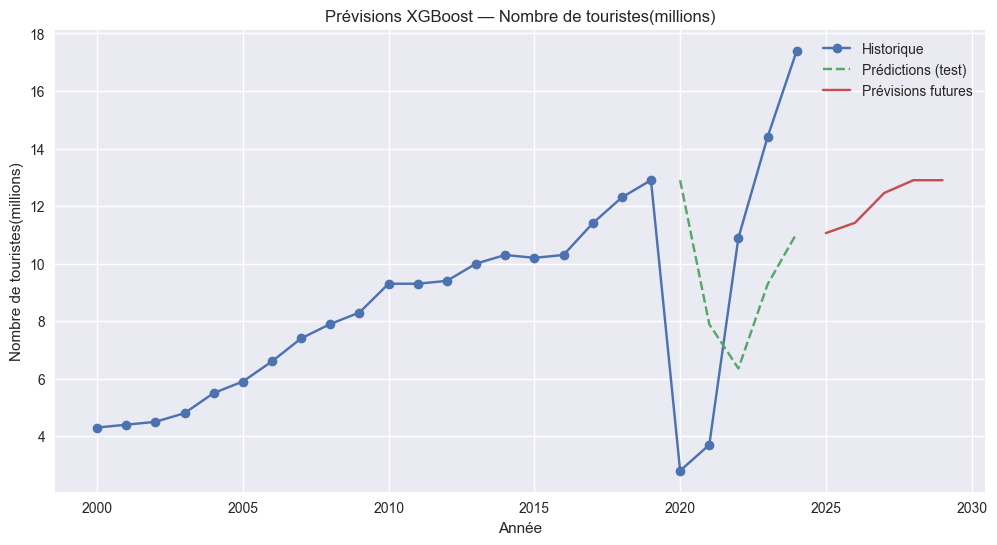


=== MÉTRIQUES XGBOOST (test) ===
                   Indicateur  Modèle   RMSE  MAPE(%)  N_test
                      Chomage XGBOOST  1.020    7.428       5
                   Dette_%PIB XGBOOST 14.378   20.381       5
      Deficit_budgétaire_%PIB XGBOOST  2.137   30.321       5
             Croissance_PIB_% XGBOOST  5.287   53.826       5
Nombre de touristes(millions) XGBOOST  6.429  117.537       5

=== PRÉVISIONS FUTURES (XGBOOST) ===
       Chomage_pred  Croissance_PIB_%_pred  Deficit_budgétaire_%PIB_pred  Dette_%PIB_pred  Nombre de touristes(millions)_pred
Annee                                                                                                                        
2025          9.179                  3.087                        -3.983           55.681                              11.061
2026          9.028                  3.686                        -3.470           53.778                              11.419
2027          9.141                  4.889          

In [40]:
# ===========================================
# XGBOOST — PRÉVISIONS + PLOTS (multi-indicateurs)
# ===========================================
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor

# ------------ PARAMÈTRES GÉNÉRAUX ------------
FILE  = r"C:\Users\adame\OneDrive\Desktop\PFA DB\DB TGR.xlsx"
SHEET = "BD"
INDICATEURS_XGB = [
    "Chomage",
    "Croissance_PIB_%",
    "Deficit_budgétaire_%PIB",
    "Dette_%PIB",
    "Nombre de touristes(millions)"
]
N_LAGS    = 5        # nombre de retards utilisés comme features
TEST_YEARS = 5       # nb d'années en test (portion la + récente)
N_FUTURE   = 5       # nb d'années à prévoir
OUT_DIR    = "xgb_plots"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------ OUTILS ------------
def safe_numeric_cleanup(df, year_col="Annee"):
    df = df.copy()
    for c in df.columns:
        if c != year_col:
            df[c] = (df[c].astype(str)
                             .str.replace(',', '.', regex=False)
                             .str.replace(' ', '', regex=False)
                             .str.replace('−', '-', regex=False)
                             .str.strip())
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=[year_col]).copy()
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
    df = df.set_index(year_col).sort_index()
    return df

def create_lagged_features(series, n_lags):
    data = pd.DataFrame({"y": series})
    for lag in range(1, n_lags + 1):
        data[f"lag_{lag}"] = data["y"].shift(lag)
    return data.dropna()

def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0)

def split_train_test_by_year_index(series, test_years=5):
    """Split temporel : dernières années en test, le reste en train."""
    years = series.index.astype(int).values
    uniq = np.sort(np.unique(years))
    if len(uniq) <= test_years:
        raise ValueError("Pas assez d'années pour split train/test. Réduisez TEST_YEARS.")
    cut = uniq[-test_years]
    return series[years < cut], series[years >= cut]

# ------------ PIPELINE XGB POUR UN INDICATEUR ------------
def xgb_forecast_one(series, var_name, n_lags=5, test_years=5, n_future=5, out_dir="xgb_plots"):
    # Split temporel
    y_train, y_test = split_train_test_by_year_index(series.dropna(), test_years=test_years)

    # Créer features de lags sur toute la série (pour aligner les indices)
    data = create_lagged_features(series, n_lags)
    # Définir index train/test en fonction des années déjà découpées
    idx_train_last = y_train.index.max()
    train = data.loc[data.index <= idx_train_last].copy()
    test  = data.loc[data.index.isin(y_test.index)].copy()

    # Si train/test trop courts, fallback
    if train.shape[0] < 6 or test.shape[0] < 1:
        print(f"⛔ Série trop courte pour XGB : {var_name}")
        return None

    X_train, y_tr = train.drop(columns=["y"]), train["y"]
    X_test,  y_te = test.drop(columns=["y"]),  test["y"]

    # Modèle XGB
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42
    )
    model.fit(X_train, y_tr)

    # Prédictions sur test (one-shot, lags réels connus)
    y_pred_test = model.predict(X_test)

    # Scores
    rmse = float(np.sqrt(mean_squared_error(y_te, y_pred_test)))
    mape = float(mape_safe(y_te, y_pred_test))

    # Prévision future multi-pas en roll-forward
    # On part de la dernière ligne de "data" (contient les lags récents)
    last_lags = data.iloc[-1, 1:].values.tolist()  # valeurs des colonnes lag_*
    fut_preds = []
    for _ in range(n_future):
        X_input = np.array(last_lags).reshape(1, -1)
        y_future = float(model.predict(X_input)[0])
        fut_preds.append(y_future)
        # update lags: nouveau y devient lag_1, l'ancien lag_1 devient lag_2, etc.
        last_lags = [y_future] + last_lags[:-1]

    # Construire index futur (années entières)
    last_year = int(series.index.max())
    future_index = pd.Index([last_year + i for i in range(1, n_future + 1)], name=series.index.name)
    fut_series = pd.Series(fut_preds, index=future_index, name="y_pred_future")

    # --------- PLOT ---------
    plt.figure()
    # Historique
    plt.plot(series.index.astype(int), series.values, marker="o", label="Historique")
    # Prédictions test
    plt.plot(y_test.index.astype(int), y_pred_test, linestyle="--", label="Prédictions (test)")
    # Prévisions futures
    plt.plot(fut_series.index.astype(int), fut_series.values, marker="x", label="Prévisions futures")
    plt.title(f"Prévisions XGBoost — {var_name}")
    plt.xlabel("Année")
    plt.ylabel(var_name)
    plt.grid(True)
    plt.legend()
    fname = os.path.join(out_dir, f"XGB_{var_name.replace('%','pct').replace(' ','_')}.png")
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()

    # Renvoyer objets utiles
    return {
        "rmse": rmse,
        "mape": mape,
        "y_test": y_test,
        "y_pred_test": pd.Series(y_pred_test, index=y_test.index, name="y_pred_test"),
        "y_pred_future": fut_series,
        "model": model
    }

# ------------ MAIN ------------
if __name__ == "__main__":
    # Charger & nettoyer
    raw = pd.read_excel(FILE, sheet_name=SHEET)
    df  = safe_numeric_cleanup(raw, year_col="Annee")

    # Résumés
    metrics_rows = []
    futures_concat = []

    for var in INDICATEURS_XGB:
        if var not in df.columns:
            print(f"⚠️ Variable absente : {var}")
            continue

        res = xgb_forecast_one(
            series=df[var], var_name=var,
            n_lags=N_LAGS, test_years=TEST_YEARS, n_future=N_FUTURE,
            out_dir=OUT_DIR
        )
        if res is None:
            continue

        metrics_rows.append({
            "Indicateur": var,
            "Modèle": "XGBOOST",
            "RMSE": res["rmse"],
            "MAPE(%)": res["mape"],
            "N_test": res["y_test"].shape[0]
        })

        fut_df = res["y_pred_future"].to_frame(name=f"{var}_pred")
        futures_concat.append(fut_df)

    # Tableau métriques
    metrics_df = pd.DataFrame(metrics_rows).sort_values("MAPE(%)").reset_index(drop=True)
    pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
    print("\n=== MÉTRIQUES XGBOOST (test) ===")
    print(metrics_df.to_string(index=False))

    # Tableau des prévisions futures (colonne par indicateur)
    if futures_concat:
        futures_table = pd.concat(futures_concat, axis=1)
        print("\n=== PRÉVISIONS FUTURES (XGBOOST) ===")
        print(futures_table.round(3).to_string())
        # Sauvegardes optionnelles
        # metrics_df.to_excel("xgb_metrics.xlsx", index=False)
        # futures_table.to_excel("xgb_forecasts_future.xlsx")
